<a href="https://colab.research.google.com/github/albertocastillosm/assignment-bank/blob/master/Essentially_Pairs_Research_%26_Strategy(Nifty_50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module Set-Up

In [ ]:
!pip install yfinance

In [ ]:
from typing import List
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Nifty 50 Data Download

In [ ]:
Nifty_50_info = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[1]
Nifty_50_info = Nifty_50_info.set_index("Company Name")
# Keep single company share E.g. if GOOG and GOOGL, keep only one
#Nifty_50_info["Symbol"] = Nifty_50_info["Symbol"].apply(lambda x: x.split(" (")[0])
#Nifty_50_info = nifty_50_info.drop_duplicates(["Symbol"])
Nifty_50_info.head()

,Symbol,Sector
Company Name,,
Adani Ports,ADANIPORTS,Infrastructure
Apollo Hospitals,APOLLOHOSP,Healthcare
Asian Paints,ASIANPAINT,Consumer Goods
Axis Bank,AXISBANK,Banking
Bajaj Auto,BAJAJ-AUTO,Automobile


In [ ]:
def download_ohlc_csv(constituent_list: List[str], start_date: str, end_date: str):
  ohlc = pd.DataFrame()
  # Get three months before so that we can calculate rolling averages and other technical indicators
  for i in constituent_list:
    df = yf.download(i, start=start_date, end=end_date)
    df['ticker'] = i
    ohlc=pd.concat([ohlc, df])
  ohlc.to_csv(f"ohlc_data.csv")

In [ ]:
# Saved data to the google drive folder so that we do not have to run this everytime
# Copy the ohlc_data.csv to your own google drive and mount it in colab to import data
# download_ohlc_csv(sp_500_info.index, "2021-01-01", "2021-08-31")
# download_ohlc_csv(sp_500_info.index, "2018-01-01", "2022-01-01")

# Data Cleaning

In [ ]:
raw_data = pd.read_csv('Data2.csv')
raw_data.head()

,Unnamed: 0,date,time,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,...,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO,Time_Cut
0,0,2020-04-27,09:15:00,275.90,1826.40,414.85,2506.6,1964.15,4435.05,355.00,...,1843.15,342.3,75.40,273.25,512.90,919.25,342.10,3358.00,176.50,0
1,1,2020-04-27,09:45:00,275.70,1825.40,420.35,2485.0,1984.05,4470.00,356.00,...,1842.00,342.2,75.85,274.80,509.95,917.35,344.10,3350.15,177.10,0
2,2,2020-04-27,10:15:00,274.80,1834.50,427.85,2482.0,2044.95,4575.60,357.35,...,1862.30,339.9,75.30,274.85,511.70,928.90,346.75,3340.75,178.65,0
3,3,2020-04-27,10:45:00,274.35,1838.25,424.65,2489.3,2083.00,4580.05,360.10,...,1854.65,339.8,75.55,276.40,512.65,927.25,345.55,3348.60,178.65,0
4,4,2020-04-27,11:15:00,274.15,1836.65,424.00,2495.7,2073.90,4564.40,361.95,...,1860.60,340.1,75.30,274.00,512.80,933.20,345.50,3344.05,178.85,0


In [ ]:
raw_data.tail()

,Unnamed: 0,date,time,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,...,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO,Time_Cut
6481,6481,2022-04-28,13:15:00,885.90,3261.00,776.50,3845.50,6774.85,15053.50,366.55,...,3587.0,817.95,434.80,1248.60,1273.00,2523.10,825.20,6585.35,522.7,0
6482,6482,2022-04-28,13:45:00,885.50,3265.40,778.40,3833.20,6744.90,15019.00,367.50,...,3599.3,814.80,435.80,1256.20,1280.00,2518.60,823.30,6595.95,526.0,0
6483,6483,2022-04-28,14:15:00,883.30,3254.10,780.95,3836.60,6753.65,15012.15,368.35,...,3593.9,815.00,437.55,1264.90,1280.05,2523.95,822.00,6605.85,524.1,0
6484,6484,2022-04-28,14:45:00,885.40,3250.75,778.00,3828.05,6712.65,15017.45,369.70,...,3580.5,811.05,435.05,1260.00,1270.00,2510.55,823.90,6614.85,522.1,0
6485,6485,2022-04-28,15:15:00,890.75,3242.80,776.50,3828.70,6727.75,15034.85,367.75,...,3580.0,811.00,435.50,1258.65,1271.55,2507.00,826.05,6607.65,522.5,1


In [ ]:
raw_data.describe()

,Unnamed: 0,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,...,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO,Time_Cut
count,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,...,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000
mean,3242.500000,594.362535,2614.379271,645.009582,3464.315418,5384.514146,11377.989716,406.345105,583.983256,3579.227552,...,3072.107231,638.890341,289.753238,874.912720,1088.835091,1699.972047,625.115811,5969.042638,465.876796,0.077860
std,1872.491255,186.216074,573.740923,138.162533,457.817643,1724.861704,4557.912792,42.293001,96.128500,217.962533,...,585.071801,147.369553,139.222237,398.262216,351.543956,552.059394,149.599538,1447.824214,155.452146,0.267972
min,0.000000,262.550000,1498.050000,336.500000,2377.750000,1785.650000,4007.000000,293.050000,387.750000,2887.050000,...,1834.000000,328.650000,75.100000,263.900000,498.350000,814.350000,339.600000,3240.000000,176.500000,0.000000
25%,1621.250000,360.287500,2102.662500,496.362500,3037.112500,3539.912500,6420.700000,376.950000,517.700000,3452.000000,...,2666.425000,533.412500,143.425000,424.712500,832.225000,1229.012500,473.925000,4520.887500,342.762500,0.000000
50%,3242.500000,700.225000,2690.525000,703.200000,3543.000000,5526.375000,10492.850000,403.825000,553.600000,3570.000000,...,3173.025000,650.150000,303.575000,964.600000,1005.475000,1541.650000,634.150000,6474.950000,484.000000,0.000000
75%,4863.750000,740.500000,3111.037500,750.000000,3816.050000,6981.712500,16102.000000,439.737500,690.037500,3719.150000,...,3576.925000,760.987500,424.587500,1232.700000,1438.175000,2334.675000,761.800000,7305.237500,600.000000,0.000000
max,6485.000000,912.300000,3577.700000,858.300000,4314.000000,7970.000000,19265.450000,501.000000,779.100000,4141.250000,...,4033.000000,883.200000,533.250000,1531.550000,1834.050000,2764.250000,860.300000,8238.800000,738.800000,1.000000


## Handling Missing Data

In [ ]:
raw_data.isnull().sum()

Unnamed: 0    0
date          0
time          0
ADANIPORTS    0
ASIANPAINT    0
AXISBANK      0
BAJAJ_AUTO    0
BAJFINANCE    0
BAJAJFINSV    0
BPCL          0
BHARTIARTL    0
BRITANNIA     0
CIPLA         0
COALINDIA     0
DIVISLAB      0
DRREDDY       0
EICHERMOT     0
GRASIM        0
HCLTECH       0
HDFCBANK      0
HDFCLIFE      0
HEROMOTOCO    0
HINDALCO      0
HINDUNILVR    0
HDFC          0
ICICIBANK     0
ITC           0
IOC           0
INDUSINDBK    0
INFY          0
JSWSTEEL      0
KOTAKBANK     0
LT            0
MnM           0
MARUTI        0
NTPC          0
NESTLEIND     0
ONGC          0
POWERGRID     0
RELIANCE      0
SBILIFE       0
SHREECEM      0
SBIN          0
SUNPHARMA     0
TCS           0
TATACONSUM    0
TATAMOTORS    0
TATASTEEL     0
TECHM         0
TITAN         0
UPL           0
ULTRACEMCO    0
WIPRO         0
Time_Cut      0
dtype: int64

In [ ]:
# Check missing data
raw_data[raw_data.isna().any(axis=1)]

,Date,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO


All missing data is on 2018-12-05, decided to remove missing data

In [ ]:
df = raw_data.dropna()
df.isnull().sum()

Unnamed: 0    0
date          0
time          0
ADANIPORTS    0
ASIANPAINT    0
AXISBANK      0
BAJAJ_AUTO    0
BAJFINANCE    0
BAJAJFINSV    0
BPCL          0
BHARTIARTL    0
BRITANNIA     0
CIPLA         0
COALINDIA     0
DIVISLAB      0
DRREDDY       0
EICHERMOT     0
GRASIM        0
HCLTECH       0
HDFCBANK      0
HDFCLIFE      0
HEROMOTOCO    0
HINDALCO      0
HINDUNILVR    0
HDFC          0
ICICIBANK     0
ITC           0
IOC           0
INDUSINDBK    0
INFY          0
JSWSTEEL      0
KOTAKBANK     0
LT            0
MnM           0
MARUTI        0
NTPC          0
NESTLEIND     0
ONGC          0
POWERGRID     0
RELIANCE      0
SBILIFE       0
SHREECEM      0
SBIN          0
SUNPHARMA     0
TCS           0
TATACONSUM    0
TATAMOTORS    0
TATASTEEL     0
TECHM         0
TITAN         0
UPL           0
ULTRACEMCO    0
WIPRO         0
Time_Cut      0
dtype: int64

In [ ]:
df.describe()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
count,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,...,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000
mean,563.023594,2461.675395,661.130512,3562.175774,4946.496810,8984.096147,406.960423,517.839324,3564.274005,810.460960,...,582.155054,2989.020436,591.200758,246.673342,668.651105,952.023121,1450.425363,525.615919,5737.553253,403.381617
std,139.410012,178.906739,68.385976,379.165822,543.680086,1180.581175,28.547936,43.218567,111.014956,49.289352,...,47.343084,213.256385,50.104032,70.999113,129.726145,65.325582,101.961891,76.307092,772.426464,41.584478
min,342.100000,2121.950000,485.400000,2827.050000,3275.000000,5526.800000,340.550000,422.000000,3320.600000,706.750000,...,453.900000,2604.950000,484.000000,130.500000,396.400000,788.300000,1160.000000,400.800000,4456.550000,331.950000
25%,463.975000,2371.100000,612.275000,3298.800000,4782.000000,8848.325000,387.825000,492.375000,3485.000000,772.900000,...,566.425000,2781.025000,566.150000,179.725000,612.550000,922.875000,1425.250000,451.000000,5032.400000,357.775000
50%,532.850000,2455.950000,664.850000,3597.850000,5029.000000,9175.000000,405.500000,515.500000,3557.500000,809.900000,...,592.200000,3053.000000,602.300000,269.950000,680.050000,971.900000,1479.800000,537.850000,5574.650000,416.050000
75%,706.200000,2580.100000,721.700000,3813.750000,5314.650000,9735.175000,425.550000,554.200000,3628.825000,836.325000,...,617.575000,3163.125000,623.975000,312.875000,727.275000,997.525000,1520.725000,594.100000,6462.000000,434.050000
max,858.700000,2861.200000,797.000000,4314.000000,5786.550000,10569.000000,479.550000,608.100000,3844.300000,959.850000,...,658.600000,3334.850000,692.050000,356.300000,982.000000,1077.600000,1611.000000,667.400000,7040.000000,493.300000


## Calculate volatility

In [ ]:
tickers = df.iloc[0]

In [ ]:
df.sort_values('date', inplace=True)

In [ ]:
df.tail()

,Unnamed: 0,date,time,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,...,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO,Time_Cut
6474,6474,2022-04-28,09:45:00,886.40,3219.70,770.1,3818.00,6662.15,14763.50,369.15,...,3558.45,801.50,432.75,1248.50,1258.00,2489.55,817.00,6589.00,517.00,0
6473,6473,2022-04-28,09:15:00,897.00,3218.05,770.5,3824.25,6693.25,14864.50,369.15,...,3560.00,805.40,433.95,1254.05,1267.40,2486.50,817.90,6582.85,520.65,0
6484,6484,2022-04-28,14:45:00,885.40,3250.75,778.0,3828.05,6712.65,15017.45,369.70,...,3580.50,811.05,435.05,1260.00,1270.00,2510.55,823.90,6614.85,522.10,0
6478,6478,2022-04-28,11:45:00,881.60,3245.00,769.5,3850.10,6626.00,14753.45,366.95,...,3556.80,807.60,433.35,1253.30,1263.50,2499.15,818.80,6578.00,519.05,0
6485,6485,2022-04-28,15:15:00,890.75,3242.80,776.5,3828.70,6727.75,15034.85,367.75,...,3580.00,811.00,435.50,1258.65,1271.55,2507.00,826.05,6607.65,522.50,1


In [ ]:
volatility = []
for i in tickers:
    df1 = df.loc[df['ticker'] == i,:]
    df1['log return'] = np.log(df1['Adj Close']/df1['Adj Close'].shift())
    std = df1['log return'].std()
    volatile = std * np.sqrt(df1.shape[0])
    volatility.append(volatile)

In [ ]:
df_volatility = pd.DataFrame({'tickers':tickers,'volatility':volatility})
df_volatility.head()

,tickers,volatility
0,MMM,0.545408
1,AOS,0.595458
2,ABT,0.536646
3,ABBV,0.605346
4,ABMD,0.915426


## Categorical encoding

In [ ]:
encoded = pd.get_dummies(df, columns=['ticker'])
encoded.head()

KeyError: ignored

## Saving to csv files

In [ ]:
# df.to_csv('ohlc_data_cleaned.csv')
# df_volatility.to_csv('ohlc_data_volatility.csv')
# df.to_csv('ohlc_data_encoded.csv')

# Exploration of Trading Pairs

In [ ]:
raw_data = pd.read_csv("Data2.csv")
raw_data.head()

,Unnamed: 0,date,time,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,...,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO,Time_Cut
0,0,2020-04-27,09:15:00,275.90,1826.40,414.85,2506.6,1964.15,4435.05,355.00,...,1843.15,342.3,75.40,273.25,512.90,919.25,342.10,3358.00,176.50,0
1,1,2020-04-27,09:45:00,275.70,1825.40,420.35,2485.0,1984.05,4470.00,356.00,...,1842.00,342.2,75.85,274.80,509.95,917.35,344.10,3350.15,177.10,0
2,2,2020-04-27,10:15:00,274.80,1834.50,427.85,2482.0,2044.95,4575.60,357.35,...,1862.30,339.9,75.30,274.85,511.70,928.90,346.75,3340.75,178.65,0
3,3,2020-04-27,10:45:00,274.35,1838.25,424.65,2489.3,2083.00,4580.05,360.10,...,1854.65,339.8,75.55,276.40,512.65,927.25,345.55,3348.60,178.65,0
4,4,2020-04-27,11:15:00,274.15,1836.65,424.00,2495.7,2073.90,4564.40,361.95,...,1860.60,340.1,75.30,274.00,512.80,933.20,345.50,3344.05,178.85,0


In [ ]:
raw_data.tail()

,Date,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ_AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
1092,2021-09-24 00:00:00+05:30,1.837013,2.137806,1.454450,1.284642,2.801974,2.409613,0.832025,1.725565,1.821743,...,1.190205,2.212673,2.704987,0.640828,2.048442,2.271034,2.476068,1.275397,1.573887,2.288555
1093,2021-09-27 00:00:00+05:30,1.844303,2.132588,1.453070,1.311472,2.802237,2.382536,0.845910,1.721146,1.813472,...,1.180554,2.203760,2.702953,0.683014,2.047183,2.237229,2.474801,1.285366,1.587278,2.254577
1094,2021-09-28 00:00:00+05:30,1.828789,2.117625,1.443298,1.310270,2.769356,2.355512,0.867083,1.683925,1.811987,...,1.196222,2.188581,2.688053,0.675903,2.055375,2.202242,2.493310,1.272819,1.582729,2.232465
1095,2021-09-29 00:00:00+05:30,1.833246,2.100721,1.434325,1.307849,2.765651,2.348846,0.883933,1.680975,1.804239,...,1.241868,2.191949,2.688965,0.678784,2.066708,2.188929,2.501822,1.273307,1.566286,2.234262
1096,2021-09-30 00:00:00+05:30,1.827705,2.076845,1.414178,1.290622,2.785766,2.368891,0.873117,1.672584,1.798231,...,1.250398,2.187628,2.676931,0.688127,2.061562,2.178302,2.508481,1.260043,1.557074,2.223829


In [ ]:
close_data = raw_data

In [ ]:
close_data['Date'] = pd.to_datetime(close_data['Date'], unit='D')

ValueError: ignored

In [ ]:
close_data

0      2017-04-28 00:00:00+05:30
1      2017-05-02 00:00:00+05:30
2      2017-05-03 00:00:00+05:30
3      2017-05-04 00:00:00+05:30
4      2017-05-05 00:00:00+05:30
                  ...           
1092   2021-09-24 00:00:00+05:30
1093   2021-09-27 00:00:00+05:30
1094   2021-09-28 00:00:00+05:30
1095   2021-09-29 00:00:00+05:30
1096   2021-09-30 00:00:00+05:30
Name: Date, Length: 1097, dtype: datetime64[ns, pytz.FixedOffset(330)]

In [ ]:
close_data = pd.to_datetime(close_data['Date'])

KeyError: ignored

In [ ]:
close_data

0      2017-04-28 00:00:00+05:30
1      2017-05-02 00:00:00+05:30
2      2017-05-03 00:00:00+05:30
3      2017-05-04 00:00:00+05:30
4      2017-05-05 00:00:00+05:30
                  ...           
1092   2021-09-24 00:00:00+05:30
1093   2021-09-27 00:00:00+05:30
1094   2021-09-28 00:00:00+05:30
1095   2021-09-29 00:00:00+05:30
1096   2021-09-30 00:00:00+05:30
Name: Date, Length: 1097, dtype: datetime64[ns, pytz.FixedOffset(330)]

In [ ]:
close_data = raw_data.pivot(index="Date",columns="ticker", values="Adj Close").dropna(how="all")
close_data.head()

KeyError: ignored

In [ ]:
#train_close = close_data["2021-01-01":"2021-05-31"]
#test_close = close_data["2021-06-01":"2021-09-31"]

#train_close = close_data["2018-01-01":"2019-12-31"]
#test_close = close_data["2020-01-01":"2021-12-31"]

train_close = close_data["2017-04-27":"2020-12-31"]
test_close = close_data["2021-01-01":"2021-09-30"]

NameError: ignored

In [ ]:
# Use train data to calculate correlation
corr_values = pd.DataFrame(train_close.corr().unstack().sort_values(kind="quicksort", ascending=False), columns=["corr_value"])
corr_values.index = corr_values.index.set_names(["ticker_1", "ticker_2"])
corr_values = corr_values.reset_index()
# Remove same tickers
corr_values = corr_values[corr_values.ticker_1 != corr_values.ticker_2]
# Remove same pairs
corr_values = corr_values.loc[pd.DataFrame(np.sort(corr_values[['ticker_1','ticker_2']],1),index=corr_values.index).drop_duplicates(keep='first').index]
display(corr_values)

,ticker_1,ticker_2,corr_value
496,DHR,TMO,0.992536
498,FRT,REG,0.992112
500,MTD,CARR,0.987411
502,CFG,FITB,0.987284
504,V,MA,0.986946
...,...,...,...
246850,OGN,YUM,NaN
246851,OGN,ZBH,NaN
246852,OGN,ZBRA,NaN
246853,OGN,ZION,NaN


## Tool to explore industry 

In [ ]:
def explore_industry_info(industry:str):
  industry_info = sp_500_info[sp_500_info["GICS Sub-Industry"] == industry]
  print(f"S&P 500 Companies under {industry} Industry:")
  display(industry_info)
  print("Correlation data on these companies:")
  display(corr_values[(corr_values.ticker_1.isin(industry_info.index)) & (corr_values.ticker_2.isin(industry_info.index))])

## Tool to explore trading pair information and correlation

In [ ]:
def explore_trading_pair_info(ticker_1:str, ticker_2:str):
  corr_value = corr_values[(corr_values.ticker_1.isin([ticker_1,ticker_2])) & (corr_values.ticker_2.isin([ticker_1,ticker_2]))].corr_value.values[0]
  print(f"Correlation Value: {corr_value}")
  display(sp_500_info.loc[[ticker_1, ticker_2]])
  
  data = train_close.reset_index()
  fig = make_subplots(specs=[[{"secondary_y": True}]])
    
  sub_fig1 = px.line(data,
                      x="Date",
                      y=ticker_1)
  sub_fig2 = px.line(data,
                      x="Date",
                      y=ticker_2)
  sub_fig2.data[0].line.color = 'lightgrey'

  fig.add_traces(sub_fig1.data + sub_fig2.data, secondary_ys = [False, True])
  fig.update_layout(title=f"Close Price of {ticker_1} vs {ticker_2}",
                    height=500,
                    yaxis=dict(title=f"{ticker_1} Close Price"),
                    yaxis2=dict(title=f"{ticker_2} Close Price"),
                    hovermode="x",
                    xaxis_rangeslider_visible=True, xaxis_rangeslider_thickness=0.05
                    )
  fig.show()

## Core Information

In [ ]:
# Correlation ranking of all S&P500 constituents
display(corr_values)

,ticker_1,ticker_2,corr_value
496,DHR,TMO,0.992536
498,FRT,REG,0.992112
500,MTD,CARR,0.987411
502,CFG,FITB,0.987284
504,V,MA,0.986946
...,...,...,...
246850,OGN,YUM,NaN
246851,OGN,ZBH,NaN
246852,OGN,ZBRA,NaN
246853,OGN,ZION,NaN


In [ ]:
# Sub-industries available within S&P500
sp_500_info["GICS Sub-Industry"].unique()

array(['Industrial Conglomerates', 'Building Products',
       'Health Care Equipment', 'Pharmaceuticals',
       'IT Consulting & Other Services', 'Interactive Home Entertainment',
       'Agricultural Products', 'Application Software',
       'Data Processing & Outsourced Services', 'Automotive Retail',
       'Independent Power Producers & Energy Traders',
       'Life & Health Insurance', 'Property & Casualty Insurance',
       'Industrial Gases', 'Internet Services & Infrastructure',
       'Airlines', 'Specialty Chemicals', 'Office REITs',
       'Health Care Supplies', 'Electric Utilities',
       'Interactive Media & Services', 'Tobacco',
       'Internet & Direct Marketing Retail', 'Paper Packaging',
       'Semiconductors', 'Multi-Utilities', 'Consumer Finance',
       'Specialized REITs', 'Water Utilities',
       'Asset Management & Custody Banks', 'Health Care Distributors',
       'Electrical Components & Equipment', 'Biotechnology',
       'Electronic Components', 'Manag

# Selecting Trading Pairs

**Pairs trading** is a strategic trading option that is used to generate profits regardless of market direction. Traders utilizing the pairs strategy determine two securities that:

1. Share similar characteristics and have a high positive correlation
2. Are trading at a price that is contradictory to their historical trading prices
3. The stocks must have similar PE Ratios

## Selecting the Industries

In this project, we will be focusing on **intra-sector pairs trade** i.e analyzing two stocks in the same industry. To make our research more exhaustive, we will be selecting pairs from industries with differing volatitility levels. 

- **Energy**: Highly Volatile due to wide fluctuations in oil prices
- **Health Care**: Medium Volatile
- **Utilities**: Least Volatile

## Shortlisting Trading Pairs

In [ ]:
## Finding out the most highly correlated stocks within Energy Industry
explore_industry_info("Oil & Gas Storage & Transportation")

S&P 500 Companies under Oil & Gas Storage & Transportation Industry:


,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
KMI,Kinder Morgan,reports,Energy,Oil & Gas Storage & Transportation,"Houston, Texas",2012-05-25,1506307,1997
OKE,Oneok,reports,Energy,Oil & Gas Storage & Transportation,"Tulsa, Oklahoma",2010-03-15,1039684,1906
WMB,Williams,reports,Energy,Oil & Gas Storage & Transportation,"Tulsa, Oklahoma",1975-03-31,107263,1908


Correlation data on these companies:


,ticker_1,ticker_2,corr_value
1462,KMI,OKE,0.957460
78374,WMB,OKE,0.639780
90530,KMI,WMB,0.580939


In [ ]:
## Exploring the trading pair of KMI - OKE
explore_trading_pair_info("KMI", "OKE")

Correlation Value: 0.9574598203437131


,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
KMI,Kinder Morgan,reports,Energy,Oil & Gas Storage & Transportation,"Houston, Texas",2012-05-25,1506307,1997
OKE,Oneok,reports,Energy,Oil & Gas Storage & Transportation,"Tulsa, Oklahoma",2010-03-15,1039684,1906


Apart from High Correlation within these 3 pairs of stocks, they must also exhibit similar **PE Ratios** for a more meainginful analysis

In [ ]:
## PE Ratio
def pe_ratio(list_Of_companies):
  output = []
  for i in list_Of_companies:
    symbol = yf.Ticker(i)
    pe = symbol.info['trailingPE']
    output.append(pe)
  return output

In [ ]:
list_of_energy_companies = ["KMI", "OKE"]#["KMI", "WMB", "OKE", "WMB", "KMI", "OKE"]
pe_ratio(list_of_energy_companies)


[41.824177, 18.910715]

Like above we notice that the 3 pairs we selected not only have a high correlation but also have similar PE Ratios - which allow us to shortlist them for Trading Pairs

In [ ]:
explore_industry_info("Managed Health Care")

S&P 500 Companies under Managed Health Care Industry:


,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
ANTM,Anthem,reports,Health Care,Managed Health Care,"Indianapolis, Indiana",2002-07-25,1156039,2014 (1946)
CNC,Centene,reports,Health Care,Managed Health Care,"St. Louis, Missouri",2016-03-30,1071739,1984
CI,Cigna,reports,Health Care,Managed Health Care,"Bloomfield, Connecticut",1976-06-30,1739940,1982
HUM,Humana,reports,Health Care,Managed Health Care,"Louisville, Kentucky",NaN,49071,1961
MOH,Molina Healthcare,reports,Health Care,Managed Health Care,"Long Beach, California",2022-03-02,1179929,1980
UNH,UnitedHealth Group,reports,Health Care,Managed Health Care,"Minnetonka, Minnesota",1994-07-01,731766,1977


Correlation data on these companies:


,ticker_1,ticker_2,corr_value
2276,HUM,UNH,0.947965
13612,UNH,MOH,0.889103
27466,HUM,MOH,0.838342
54350,CNC,UNH,0.737316
56852,CNC,CI,0.727926
57828,HUM,CNC,0.724295
65772,UNH,CI,0.693433
76870,CNC,MOH,0.646482
78608,CI,HUM,0.638569
83350,ANTM,CI,0.617140


In [ ]:
list_of_healthcare_companies = ["HUM","UNH"]#["ANTM", "UNH", "CI", "ANTM", "UNH", "MOH", "UNH", "HUM", "HUM", "MOH"]
pe_ratio(list_of_healthcare_companies)

[18.668308, 26.589119]

From the above list, we would probably be taking only 2 pairs that also exhibit a similar PE Ratio - CI & ANTM as well as UNH & MOH

In [ ]:
explore_industry_info("Electric Utilities")

S&P 500 Companies under Electric Utilities Industry:


,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
LNT,Alliant Energy,reports,Utilities,Electric Utilities,"Madison, Wisconsin",2016-07-01,352541,1917
AEP,American Electric Power,reports,Utilities,Electric Utilities,"Columbus, Ohio",1957-03-04,4904,1906
ED,Con Edison,reports,Utilities,Electric Utilities,"New York City, New York",NaN,1047862,1823
D,Dominion Energy,reports,Utilities,Electric Utilities,"Richmond, Virginia",NaN,715957,1983
DUK,Duke Energy,reports,Utilities,Electric Utilities,"Charlotte, North Carolina",1976-06-30,1326160,1904
EIX,Edison International,reports,Utilities,Electric Utilities,"Rosemead, California",1957-03-04,827052,1886
ETR,Entergy,reports,Utilities,Electric Utilities,"New Orleans, Louisiana",1957-03-04,65984,1913
EVRG,Evergy,reports,Utilities,Electric Utilities,"Kansas City, Missouri",2018-06-05,1711269,1909
FE,FirstEnergy,reports,Utilities,Electric Utilities,"Akron, Ohio",NaN,1031296,1997


Correlation data on these companies:


,ticker_1,ticker_2,corr_value
3834,ETR,AEP,0.935295
4700,ETR,SO,0.929906
6430,LNT,WEC,0.920270
11598,LNT,SO,0.896830
16332,SO,AEP,0.878761
...,...,...,...
150186,FE,DUK,0.214312
156506,PPL,WEC,0.166082
166922,FE,D,0.086058
168296,LNT,FE,0.075408


In [ ]:
list_of_utilities_companies = ["ETR","AEP"]#["LNT", "ED", "DUK", "ED", "ETR", "SO", "DUK", "LNT", "ETR", "ED"]
pe_ratio(list_of_utilities_companies)

[22.31591, 19.099617]

From the above list, we would probably be taking only 3 pairs that also exhibit a similar PE Ratio - LNT & ED, DUK & ED and DUK & LNT

## Finalizing Trading Pairs

Using Intra-Sector Pairs Trade, we are able to finalize 8 Trading Pairs:
1. KMI & WMB [Energy]
2. OKE & WMB [Energy]
3. KMI & OKE [Energy]
4. CI & ANTM [HealthCare]
5. UNH & MOH [HealthCare]
6. LNT & ED [Utilities]
7. DUK & ED [Utilities]
8. DUK & LNT [Utilities]

In [ ]:
'''
pair1 = ["KMI", "WMB"]
pair2 = ["OKE", "WMB"]
pair3 = ["KMI", "OKE"]
pair4 = ["CI", "ANTM"]
pair5 = ["UNH", "MOH"]
pair6 = ["LNT", "ED"]
pair7 = ["DUK", "ED"]
pair8 = ["DUK", "LNT"]
'''

pair1 = ["KMI", "OKE"]
pair2 = ["HUM","UNH"]
pair3 = ["ETR","AEP"]

#start_date = '2019-01-01'
#end_date = '2021-12-31'
start_date = '2019-01-01'
end_date = '2022-01-01'

def get_df(list_tickers):
  df = pd.DataFrame()
  for ticker in list_tickers:
    current = yf.Ticker(ticker).history(start=start_date, end=end_date).filter(["Close"], axis=1).rename({"Close": ticker}, axis=1)
    df = pd.concat([df, current], axis=1)
  return df

pairs = [pair1,pair2,pair3]
pairs

[['KMI', 'OKE'], ['HUM', 'UNH'], ['ETR', 'AEP']]

In [ ]:
df_pair_dict = {}
for pair in pairs:
  df = get_df(pair)
  trade_pair_name = '-'.join(pair)
  dictionary = {'dataframe':df}
  df_pair_dict.update({trade_pair_name:dictionary})
df_pair_dict['ETR-AEP']['dataframe']

,ETR,AEP
Date,,
2019-01-02,74.074654,64.972565
2019-01-03,74.224571,64.821129
2019-01-04,74.780136,65.417946
2019-01-07,74.427399,65.052727
2019-01-08,75.750160,65.854431
...,...,...
2021-12-27,108.882004,85.651268
2021-12-28,109.923370,86.762718
2021-12-29,110.512825,87.126656


# GroundTruth Spreads for Close Price

https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a

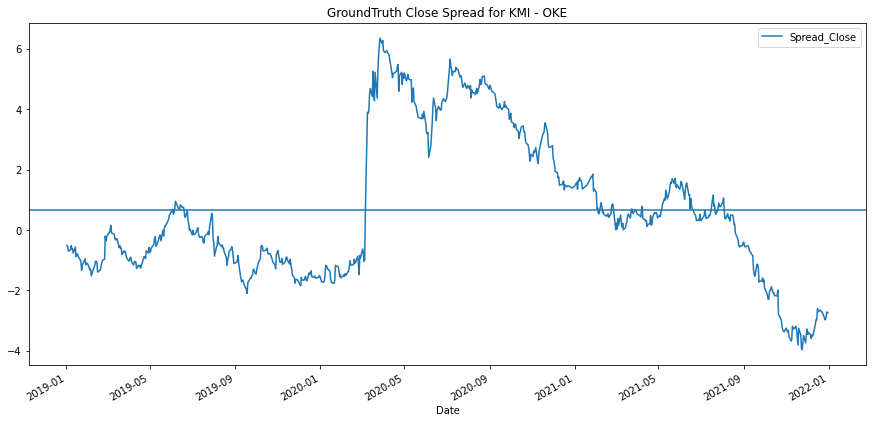

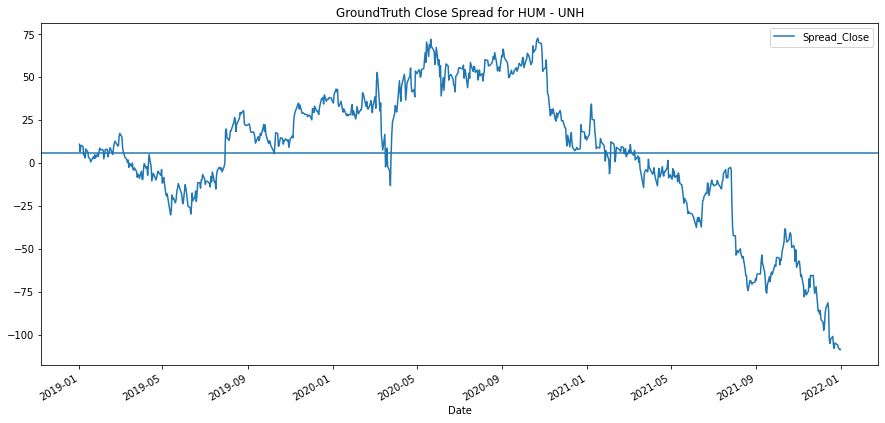

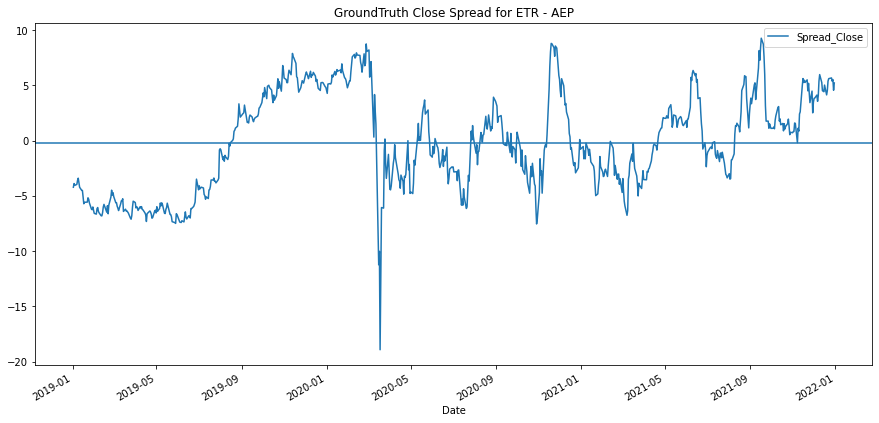

In [ ]:
import statsmodels.api as sm
from matplotlib import pyplot

for trade_pair_name,dictionary in df_pair_dict.items():
    df = dictionary['dataframe']
    s1,s2= df.columns.values.tolist()

    # ordinary least square model, fit linear regression

    est = sm.OLS(df[s1], df[s2])
    est = est.fit()
    alpha = -est.params[0]
    df['Spread_Close'] = df[s1] + (df[s2] * alpha)
    df['Spread_Close'].plot(figsize=(15,7))
    
    df_pair_dict[trade_pair_name].update({'dataframe':df})

    pyplot.title('GroundTruth Close Spread for {} - {}'.format(s1,s2))
    pyplot.axhline(df['Spread_Close'].mean())
    pyplot.legend(['Spread_Close'])
    pyplot.show()

In [ ]:
df_pair_dict['ETR-AEP']['dataframe']

,ETR,AEP,Spread_Close
Date,,,
2019-01-02,74.074654,64.972565,-4.221969
2019-01-03,74.224571,64.821129,-3.889560
2019-01-04,74.780136,65.417946,-4.053202
2019-01-07,74.427399,65.052727,-3.965825
2019-01-08,75.750160,65.854431,-3.609175
...,...,...,...
2021-12-27,108.882004,85.651268,5.666054
2021-12-28,109.923370,86.762718,5.368043
2021-12-29,110.512825,87.126656,5.518927


# Train-Val-Test Split

In [ ]:
from sklearn.metrics import mean_squared_error
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)

In [ ]:
'''
df_spread = df.copy()
train_size = int(len(df_spread) * 0.9)
val_size = int((len(df_spread) - train_size) * 0.5)# - 30
test_size = len(df_spread) - train_size - val_size
train, val, test = df_spread[0:train_size], df_spread[train_size:train_size + val_size], df_spread[train_size + val_size:len(df)]
print(len(train), len(val), len(test))
'''

680 38 38


In [ ]:
min(train_close.index),max(train_close.index)

('2019-01-02', '2020-12-31')

In [ ]:
min(test_close.index),max(test_close.index)

('2021-01-04', '2021-12-31')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

for trade_pair_name,dictionary in df_pair_dict.items():
    df = dictionary['dataframe']
    s1,s2,_ = df.columns.values.tolist()
    df_spread = df.copy()
    #train_close = close_data["2019-01-01":"2020-12-31"]
    #test_close = close_data["2021-01-01":"2021-12-31"]

    df_spread_col =  df_spread[['Spread_Close']].copy()
    train_size = int(len(train_close.index) * 0.9)
    val_size = int(len(train_close.index)-train_size)
    test_size = len(df_spread_col) - train_size - val_size
    train, val, test = df_spread[0:train_size], df_spread[train_size:train_size + val_size], df_spread[train_size + val_size:len(df)]

    train1 = train[['Spread_Close']].copy()
    test1 = test[['Spread_Close']].copy()
    val1 = val[['Spread_Close']].copy()


    print(f'\n{trade_pair_name}')
    print('train size = {} , percentage = {}%'.format(train_size, round(train_size*100/len(df_spread_col),2)))
    print('val size = {} , percentage = {}%'.format(val_size, round(val_size*100/len(df_spread_col),2)))
    print('test size = {} , percentage = {}%'.format(test_size, round(test_size*100/len(df_spread_col),2)))

    look_back = 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Create function for creating dataset with look back
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i, :]
            dataX.append(a)
            dataY.append(dataset[(i+1):(i+1+look_back), 0])
        #print(len(dataY[0]))
        #print(dataY)
        return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

    # Generate dataset for trainX, trainY, testX, testY
    trainX_untr, trainX, trainY_untr, trainY = create_dataset(train1.values, look_back)
    valX_untr, valX, valY_untr, valY = create_dataset(val1.values, look_back)
    testX_untr, testX, testY_untr, testY = create_dataset(test1.values, look_back)


    # Reshape X for model training
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    print(trainX.shape,trainY.shape)
    print(valX.shape,valY.shape)
    print(testX.shape,testY.shape)

    # update dictionary
    new_dict = {'df_spread':df_spread,
                'df_spread_col':df_spread_col,
        
                'trainX_untr':trainX_untr,
                'trainX':trainX,
                'trainY_untr':trainY_untr,
                'trainY':trainY,

                'valX_untr':valX_untr,
                'valX':valX,
                'valY_untr':valY_untr,
                'valY':valY,

                'testX_untr':testX_untr,
                'testX':testX,
                'testY_untr':testY_untr,
                'testY':testY
                
                }
    df_pair_dict[trade_pair_name].update(new_dict)


KMI-OKE
train size = 454 , percentage = 59.97%
val size = 51 , percentage = 6.74%
test size = 252 , percentage = 33.29%
(453, 1, 1) (453, 1)
(50, 1, 1) (50, 1)
(251, 1, 1) (251, 1)

HUM-UNH
train size = 454 , percentage = 59.97%
val size = 51 , percentage = 6.74%
test size = 252 , percentage = 33.29%
(453, 1, 1) (453, 1)
(50, 1, 1) (50, 1)
(251, 1, 1) (251, 1)

ETR-AEP
train size = 454 , percentage = 59.97%
val size = 51 , percentage = 6.74%
test size = 252 , percentage = 33.29%
(453, 1, 1) (453, 1)
(50, 1, 1) (50, 1)
(251, 1, 1) (251, 1)


In [ ]:
'''
df_spread_col =  df_spread[['Spread_Close']].copy()
train_size = int(len(df_spread_col) * 0.9)
val_size = int((len(df_spread_col) - train_size) * 0.5)# - 30
test_size = len(df_spread_col) - train_size - val_size
train, val, test = df_spread[0:train_size], df_spread[train_size:train_size + val_size], df_spread[train_size + val_size:len(df)]

#train1 = train[['Spread_Close']].copy()
#test1 = test[['Spread_Close']].copy()
#val1 = val[['Spread_Close']].copy()

print(len(train), len(val), len(test))
'''

681 38 38


# Spread Prediction using Kalman Filter

The Kalman Filter is used to dynamically track the hedging ratio between the two in order to keep the spread stationary (and hence mean reverting).

In [ ]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
 
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
 
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
 
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
 
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def normalize(series):
    return (series - np.mean(series)) / np.std(series)

In [ ]:
def kalman_filter_prediction(df_spread,testX,trade_pair_name):
    state_means = - KalmanFilterRegression(KalmanFilterAverage(df_spread[s1]),KalmanFilterAverage(df_spread[s2]))[:,0]
    results = normalize(df_spread[s1] + (df_spread[s2] * state_means)) # normalize spread
    forecast = results[-len(testX):].values #forecast spread for test set
    yhat_KF = forecast

    yhat_KF_mse = []
    look_back = 1
    # calculate mse
    mse = 0.0
    if look_back == 1:
        for i in range(len(forecast)):
            temp = []
            temp.append(forecast[i])
            yhat_KF_mse.append(np.array(temp))
        mse = acc_metric(normalize(testY_untr), yhat_KF_mse)
    else:
        mse = 0.0

    # plot predicted spread graphs
    normalize(df_spread['Spread_Close']).plot(figsize=(15,7))
    results.plot(figsize=(15,7))
    pyplot.axhline(normalize(df_spread['Spread_Close']).mean(), color='black')
    pyplot.axhline(1.0, color='red', linestyle='--')
    pyplot.axhline(-1.0, color='green', linestyle='--')
    pyplot.legend(['Spread z-score', 'Kalman_Predicted_Spread', 'Mean', '+1 (Short)', '-1 (Long)'])
    pyplot.title(f'{trade_pair_name}')
    pyplot.show()

    return yhat_KF

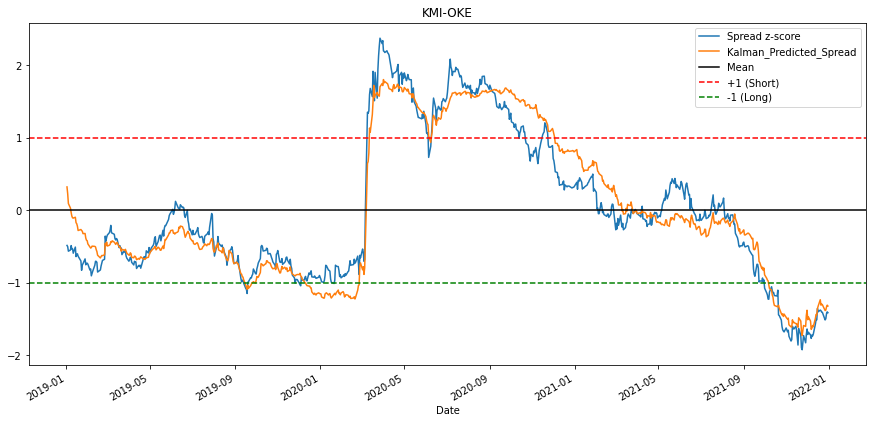

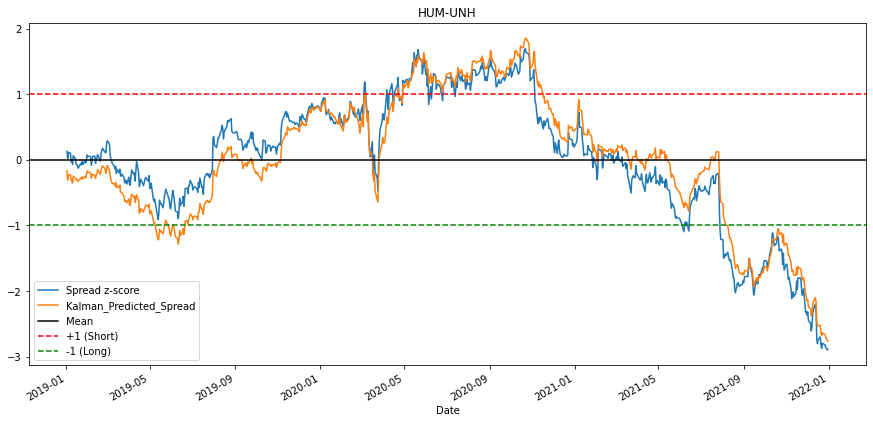

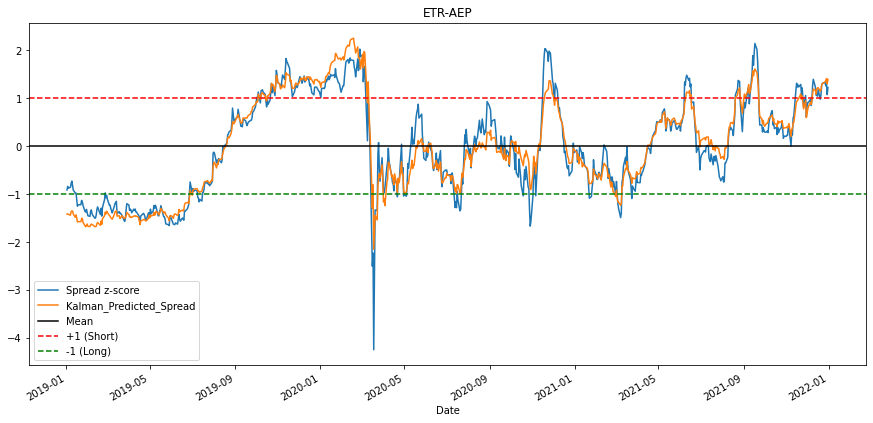

In [ ]:
for trade_pair_name,dictionary in df_pair_dict.items():
    df = dictionary['dataframe']
    s1,s2,_ = df.columns.values.tolist()

    df_spread,testX = dictionary['df_spread'],dictionary['testX']

    yhat_KF = kalman_filter_prediction(df_spread,testX,trade_pair_name)

    # update dictionary with yhat_KF
    df_pair_dict[trade_pair_name].update({'yhat_KF':yhat_KF})


# Spread Prediction using Long Short-Term Memory (LSTM)

To predict the spread between co-integrated pairs. Then we use same co-integrated mean-reversion trading strategy to compare returns and sharpe ratio.

Predicting the spread of 1-time-step: 1day

https://github.com/sk3391/CS230/blob/master/Pairs%20Trading%20using%20Deep%20Learning.ipynb

In [ ]:
import keras
keras.__version__

'2.8.0'

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Training Procedure

=========== KMI-OKE ===========
Epoch 1/5
23/23 - 7s - loss: 0.1159 - accuracy: 0.0044 - val_loss: 0.0314 - val_accuracy: 0.0400 - 7s/epoch - 310ms/step
Epoch 2/5
23/23 - 0s - loss: 0.0237 - accuracy: 0.0044 - val_loss: 0.0139 - val_accuracy: 0.0400 - 292ms/epoch - 13ms/step
Epoch 3/5
23/23 - 0s - loss: 0.0043 - accuracy: 0.0044 - val_loss: 0.0067 - val_accuracy: 0.0400 - 281ms/epoch - 12ms/step
Epoch 4/5
23/23 - 0s - loss: 0.0015 - accuracy: 0.0044 - val_loss: 0.0070 - val_accuracy: 0.0400 - 289ms/epoch - 13ms/step
Epoch 5/5
23/23 - 0s - loss: 0.0014 - accuracy: 0.0044 - val_loss: 0.0065 - val_accuracy: 0.0400 - 292ms/epoch - 13ms/step


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 1, 256)            264192    
                                                                 
 lstm_51 (LSTM)              (None, 256)               525312    


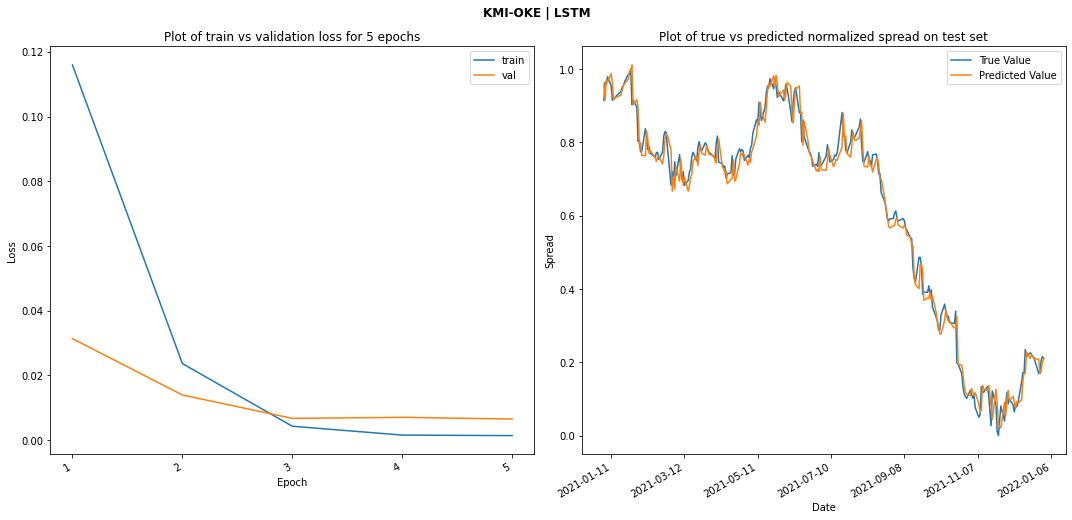

=========== HUM-UNH ===========
Epoch 1/5
23/23 - 6s - loss: 0.1667 - accuracy: 0.0022 - val_loss: 0.0488 - val_accuracy: 0.0400 - 6s/epoch - 242ms/step
Epoch 2/5
23/23 - 0s - loss: 0.0214 - accuracy: 0.0044 - val_loss: 0.0265 - val_accuracy: 0.0400 - 288ms/epoch - 13ms/step
Epoch 3/5
23/23 - 0s - loss: 0.0106 - accuracy: 0.0044 - val_loss: 0.0191 - val_accuracy: 0.0400 - 280ms/epoch - 12ms/step
Epoch 4/5
23/23 - 0s - loss: 0.0056 - accuracy: 0.0044 - val_loss: 0.0091 - val_accuracy: 0.0400 - 298ms/epoch - 13ms/step
Epoch 5/5
23/23 - 0s - loss: 0.0031 - accuracy: 0.0044 - val_loss: 0.0053 - val_accuracy: 0.0400 - 276ms/epoch - 12ms/step


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 1, 256)            264192    
                                                                 
 lstm_53 (LSTM)              (None, 256)               525312    


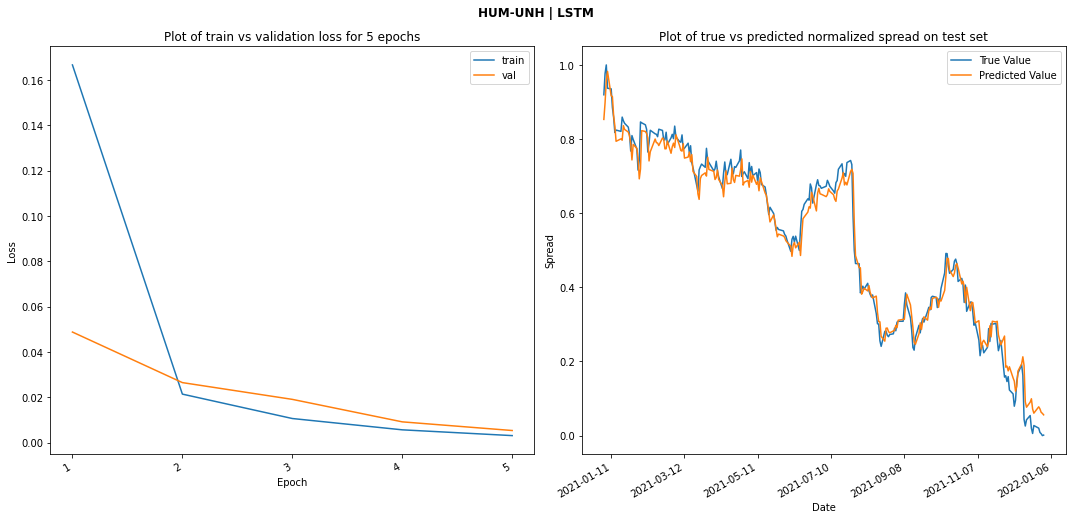

=========== ETR-AEP ===========
Epoch 1/5
23/23 - 5s - loss: 0.2249 - accuracy: 0.0022 - val_loss: 0.0261 - val_accuracy: 0.0400 - 5s/epoch - 212ms/step
Epoch 2/5
23/23 - 0s - loss: 0.0173 - accuracy: 0.0022 - val_loss: 0.0235 - val_accuracy: 0.0400 - 289ms/epoch - 13ms/step
Epoch 3/5
23/23 - 0s - loss: 0.0082 - accuracy: 0.0044 - val_loss: 0.0236 - val_accuracy: 0.0400 - 285ms/epoch - 12ms/step
Epoch 4/5
23/23 - 0s - loss: 0.0062 - accuracy: 0.0044 - val_loss: 0.0186 - val_accuracy: 0.0400 - 299ms/epoch - 13ms/step
Epoch 5/5
23/23 - 0s - loss: 0.0052 - accuracy: 0.0044 - val_loss: 0.0173 - val_accuracy: 0.0400 - 278ms/epoch - 12ms/step


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 1, 256)            264192    
                                                                 
 lstm_55 (LSTM)              (None, 256)               525312    


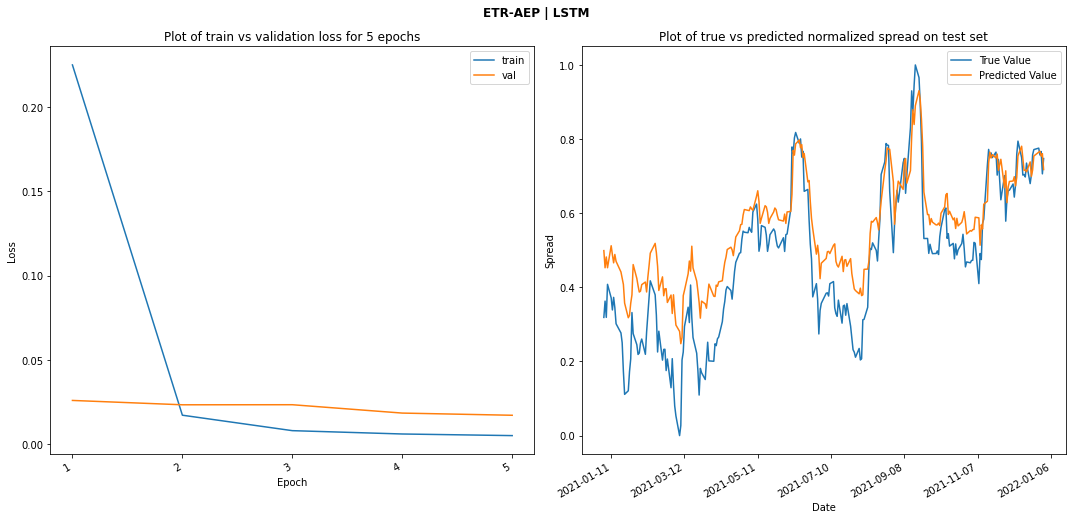

In [ ]:
import matplotlib.dates as mdates
for trade_pair_name,dictionary in df_pair_dict.items():
    
    print(f'=========== {trade_pair_name} ===========')
    df = dictionary['dataframe']
    s1,s2,_ = df.columns.values.tolist()

    trainX,trainY,valX,valY,testX,testY = dictionary['trainX'],dictionary['trainY'],dictionary['valX'],dictionary['valY'],dictionary['testX'],dictionary['testY']

    # Training Parameters
    look_back = 1
    epochs = 5
    batch_size=20

    # Train LSTM model
    model = Sequential()
    model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(look_back))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    history = model.fit(trainX, trainY, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(valX, valY), 
                        verbose=2, shuffle=True)
    print('\n')
    print(model.summary())

    pyplot.figure(figsize=(15,7))

    # Plot line graph to show amount loss according the the epoch (overfitting after 2 to 3 epoch)
    pyplot.subplot(1, 2, 1)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.title(f'Plot of train vs validation loss for {epochs} epochs')
    pyplot.xticks(np.arange(len(history.history['loss'])), np.arange(1, len(history.history['loss'])+1))
    pyplot.xlabel('Epoch') 
    pyplot.ylabel('Loss')
    pyplot.legend()
    #pyplot.show()

    # Forecast Normalized Spread on Test Data
    # Make prediction using testX and plotting line graph against testY
    pyplot.subplot(1, 2, 2)
    yhat = model.predict(testX)
    pyplot.plot(df.tail(test_size-1).index, testY, label='True Value')
    pyplot.plot(df.tail(test_size-1).index, yhat, label='Predicted Value')
    pyplot.title(f'Plot of true vs predicted normalized spread on test set')
    #pyplot.xticks(np.arange(len(testX)), np.arange(1, len(testX)+1))
    pyplot.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    pyplot.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
    pyplot.gcf().autofmt_xdate()
    pyplot.xlabel('Date') 
    pyplot.ylabel('Spread')
    pyplot.legend()
    
    pyplot.suptitle(f'{trade_pair_name} | LSTM',y=1, horizontalalignment='center', verticalalignment='bottom',fontweight ="bold")
    pyplot.tight_layout()
    pyplot.show()

    # Scaler Inverse Y back to normal value
    yhat_LSTM = scaler.inverse_transform(yhat)
    testY_LSTM = scaler.inverse_transform(testY)
    # update dictionary
    df_pair_dict[trade_pair_name].update({'yhat_LSTM':yhat_LSTM,'testY_LSTM':testY_LSTM})
    # delete lstm model
    del model    

# Visualize Predicted Spreads

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go

for trade_pair_name,dictionary in df_pair_dict.items():
    
    print(f'=========== {trade_pair_name} ===========')
    df = dictionary['dataframe']
    s1,s2,_ = df.columns.values.tolist()

    df_spread = dictionary['df_spread']
    testX, testY_LSTM, yhat_LSTM, yhat_KF = dictionary['testX'],dictionary['testY_LSTM'],dictionary['yhat_LSTM'],dictionary['yhat_KF']


    predictDates = df_spread.tail(len(testX)).index
    testY_reshape = normalize(testY_LSTM).reshape(len(testY_LSTM))
    yhat_reshape = normalize(yhat_LSTM).reshape(len(yhat_LSTM))
    kalman_reshape = normalize(yhat_KF).reshape(len(yhat_KF))
    #Plot predicted and actual line graph
    layout = go.Layout(
            title=f'{trade_pair_name} : Normalized Spread vs Time',
            xaxis=dict(
            title='Time Period',
            titlefont=dict(
                family='Arial, sans-serif',
                size=18
            )),
            yaxis=dict(
            title='Normalized Spread',
            titlefont=dict(
                family='Arial, sans-serif',
                size=18
            )))
    actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Spread')
    predict_lstm_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'LSTM Predict Spread')
    predict_kalman_chart = go.Scatter(x=predictDates, y=kalman_reshape, name= 'Kalman Filter Predict Spread')
    fig = go.Figure(data = [predict_kalman_chart, predict_lstm_chart, actual_chart], layout = layout)
    py.iplot(fig)

=========== KMI-OKE ===========


=========== HUM-UNH ===========


=========== ETR-AEP ===========


# Execute Trading Strategy (Mean Reversion)

In [ ]:
# https://towardsdatascience.com/calculating-sharpe-ratio-with-python-755dcb346805
def calculate_sharpe_ratio(daily_return, risk_free_rate=0.0):
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (daily_return.mean() - risk_free_rate) / daily_return.std()
    # Annualize Daily Sharpe Ratio, n = 252 trading days
    annual_sharpe_ratio = 252**(0.5) * daily_sharpe_ratio
    return annual_sharpe_ratio

# https://medium.datadriveninvestor.com/the-sharpe-ratio-with-python-from-scratch-fbb1d5e490b9#:~:text=The%20Sharpe%20Ratio%20is%20measured,returns%20(the%20risk%20portion).
# https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM/
def trade(S1, S2, spread, window1, window2,s1_name,s2_name):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean() #sma window 1
    ma2 = spread.rolling(window=window2, center=False).mean() #sma window 2
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading, Start with no money and no positions
    money = 0 # total portfolio cash
    countS1 = 0 # position of s1
    countS2 = 0 # position of s2

    df_return = pd.DataFrame(spread).copy()
    cum_return_list = []
    pairs_positions = []

    for i in range(len(spread)):

        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * spread[i]
            countS1 -= 1
            countS2 += spread[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * spread[i]
            countS1 += 1
            countS2 -= spread[i]
            
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] - S2[i] * countS2
            countS1 = 0
            countS2 = 0
        #print(countS1,countS2)
        cum_return_list.append(money)
        pairs_positions.append(countS1+countS2)

    df_return['positions'] = pairs_positions
    df_return['S1'] = S1 # actual price of stock 1
    df_return['S2'] = S2 # actual price of stock 2

    df_return[s1_name] = -1.0 * df_return['S1'] * df_return['positions'] # -1 account for shorts
    df_return[s2_name] =  df_return['S2'] * df_return['positions'] 
    df_return['total_return'] = df_return[s1_name] + df_return[s2_name]

    #df_return['daily_return'] = df_return['total_return'].pct_change()

    df_return['cum_return'] = df_return['total_return'].cumsum()

    df_return['daily_return'] = df_return['cum_return'].pct_change()
    #df_return['daily_return'] = df_return['cum_return'].pct_change(1) # pct_change() does not account for negative cum_return values
    #df_return['daily_return'] = df_return['cum_return'].diff() / df_return['cum_return'].abs().shift() # to account for negative cum_return values
    
    df_return.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_return = df_return.dropna()

    return money,df_return

In [ ]:
test_data['S1']

Date
2021-01-05     91.521088
2021-01-06     92.969154
2021-01-07     89.760712
2021-01-08     90.375893
2021-01-11     89.334801
                 ...    
2021-12-27    108.882004
2021-12-28    109.923370
2021-12-29    110.512825
2021-12-30    109.677765
2021-12-31    110.670021
Name: S1, Length: 251, dtype: float64

In [ ]:
s1_name,s2_name = s1,s2

In [ ]:
money, dfs = trade(test_data['S1'], test_data['S2'], test_data[method], window1, window2,s1_name,s2_name)
dfs

,LSTM_Predicted_Spread,positions,S1,S2,ETR,AEP,total_return,cum_return,daily_return
Date,,,,,,,,,
2021-02-10,0.075964,-1.553357,90.868057,76.670540,141.150512,-119.096702,22.053810,42.875797,1.059160
2021-02-11,0.576996,0.000000,90.466560,75.654785,-0.000000,0.000000,0.000000,42.875797,0.000000
2021-02-12,1.124427,0.000000,90.705544,75.328972,-0.000000,0.000000,0.000000,42.875797,0.000000
2021-02-16,1.548201,0.000000,89.615814,74.926506,-0.000000,0.000000,0.000000,42.875797,0.000000
2021-02-17,1.142404,-0.142404,89.080513,75.213982,12.685450,-10.710796,1.974654,44.850451,0.046055
...,...,...,...,...,...,...,...,...,...
2021-12-27,5.486644,0.000000,108.882004,85.651268,-0.000000,0.000000,0.000000,54576.819157,0.000000
2021-12-28,5.531838,0.000000,109.923370,86.762718,-0.000000,0.000000,0.000000,54576.819157,0.000000
2021-12-29,5.319050,-4.319050,110.512825,87.126656,477.310451,-376.304409,101.006042,54677.825199,0.001851


In [ ]:
calculate_sharpe_ratio(daily_return=dfs['daily_return'], risk_free_rate=0.0)

0.890282894285436

In [ ]:
dfs['total_return'].sum()

51935.61836517994

In [ ]:
dfs['cum_return'][-1]

51959.31121357689

In [ ]:
money

39282.3381972165


=========== KMI-OKE ===========

Actual_Spread



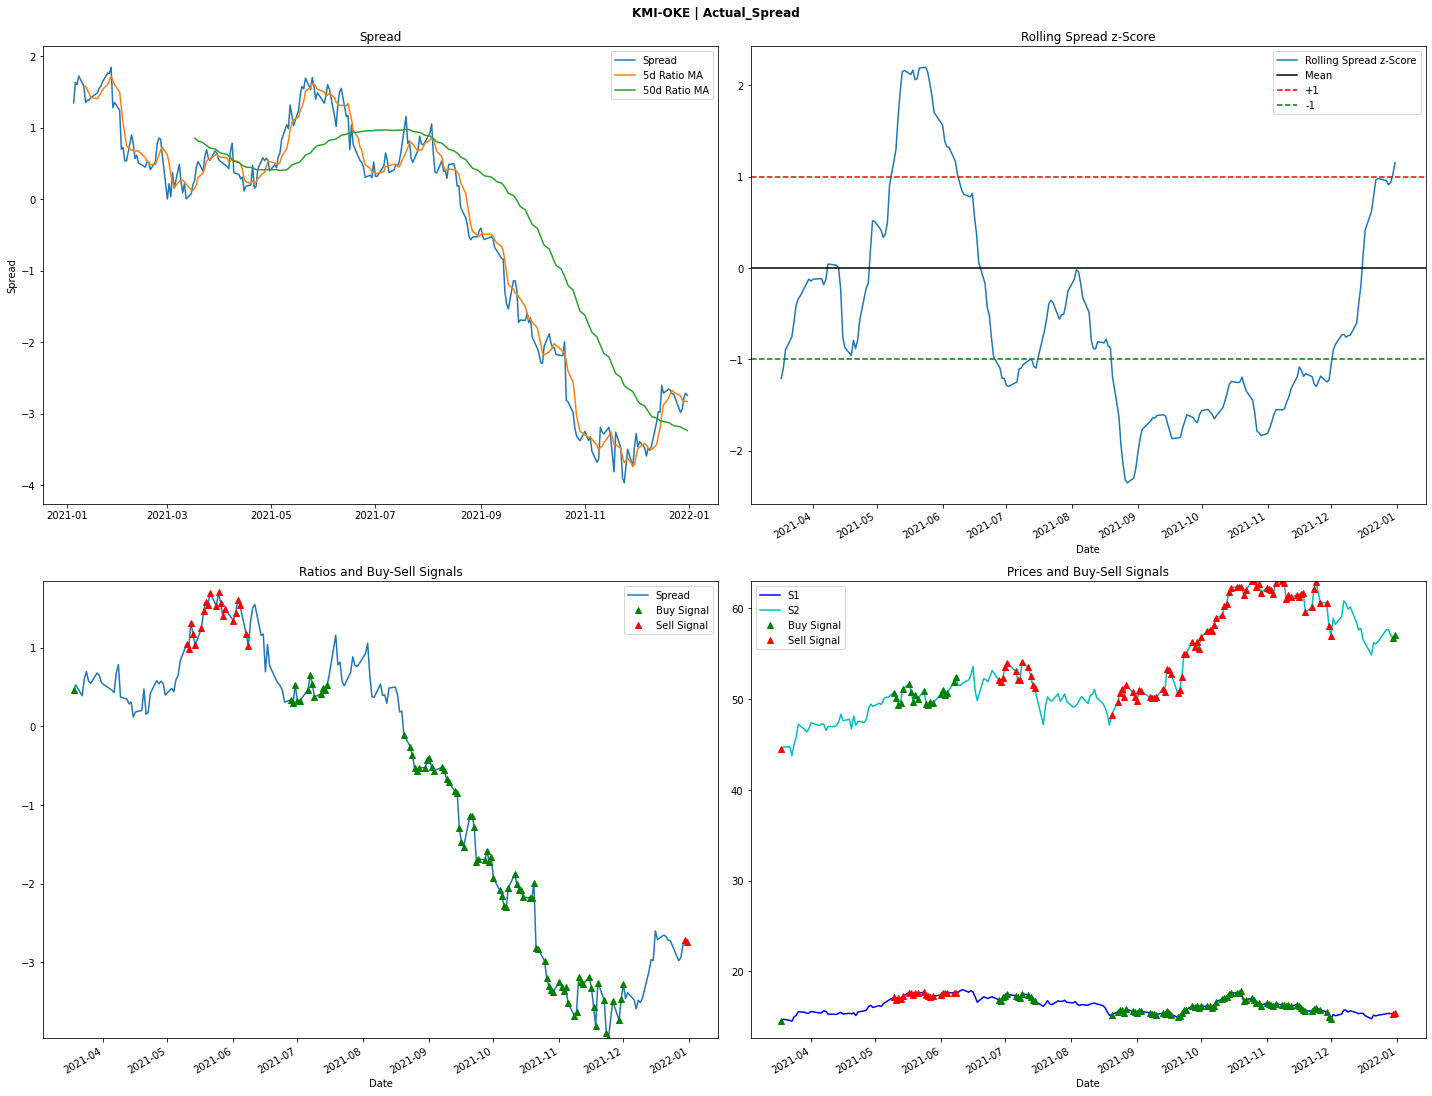


Kalman_Predicted_Spread



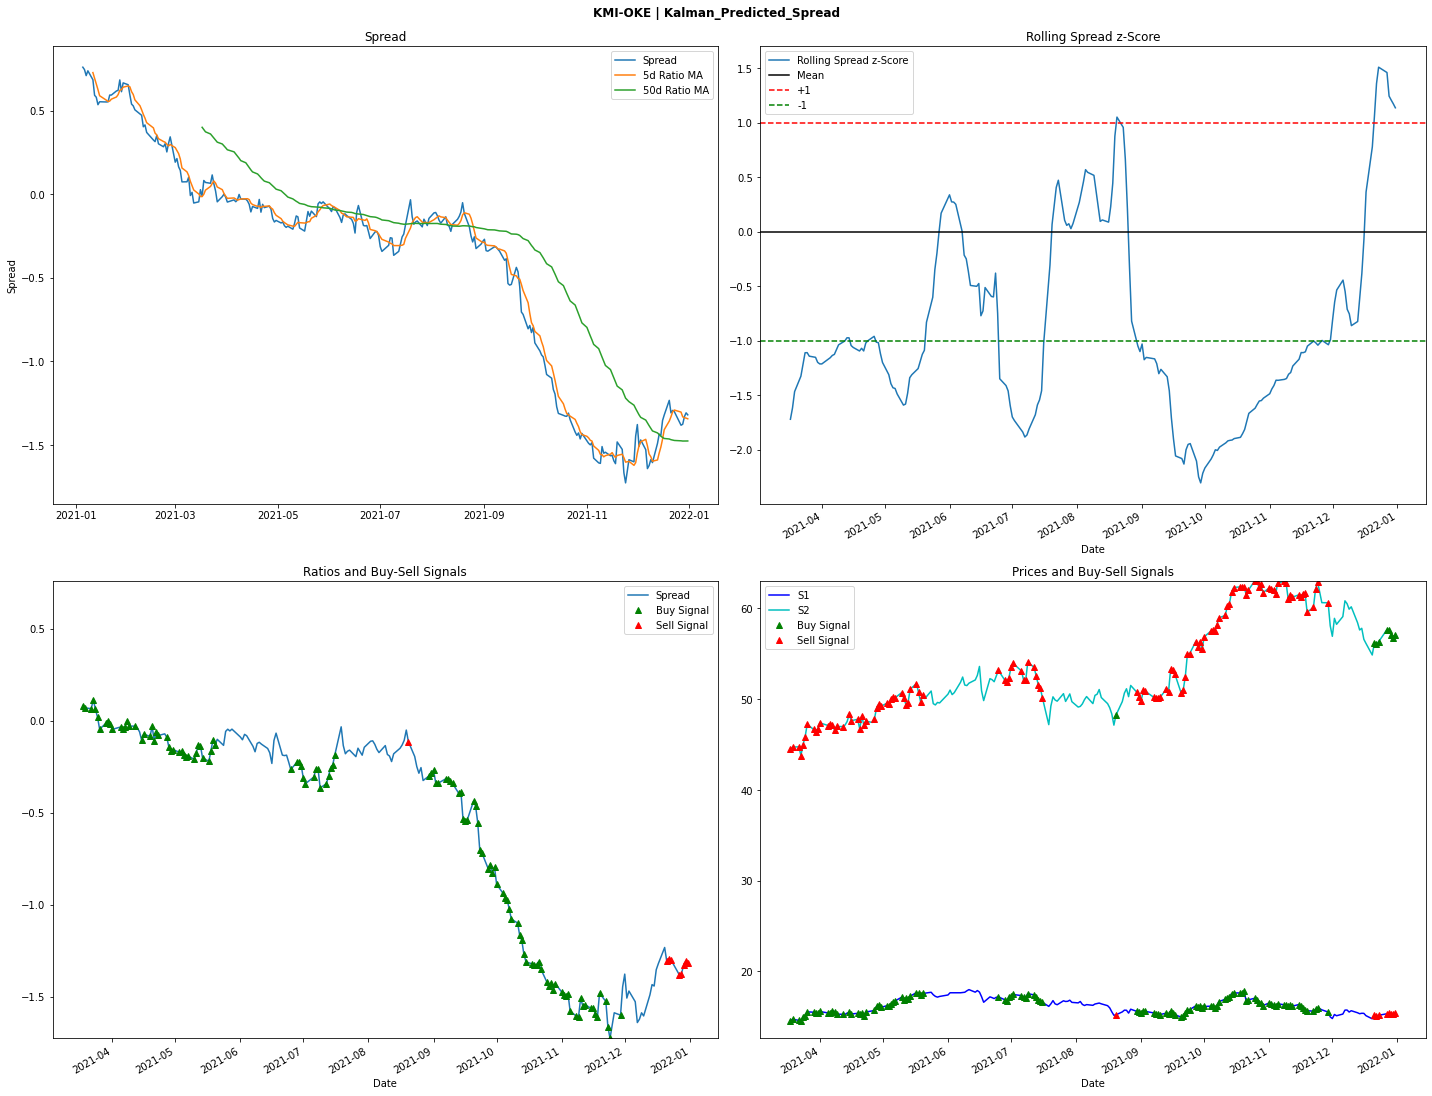


LSTM_Predicted_Spread



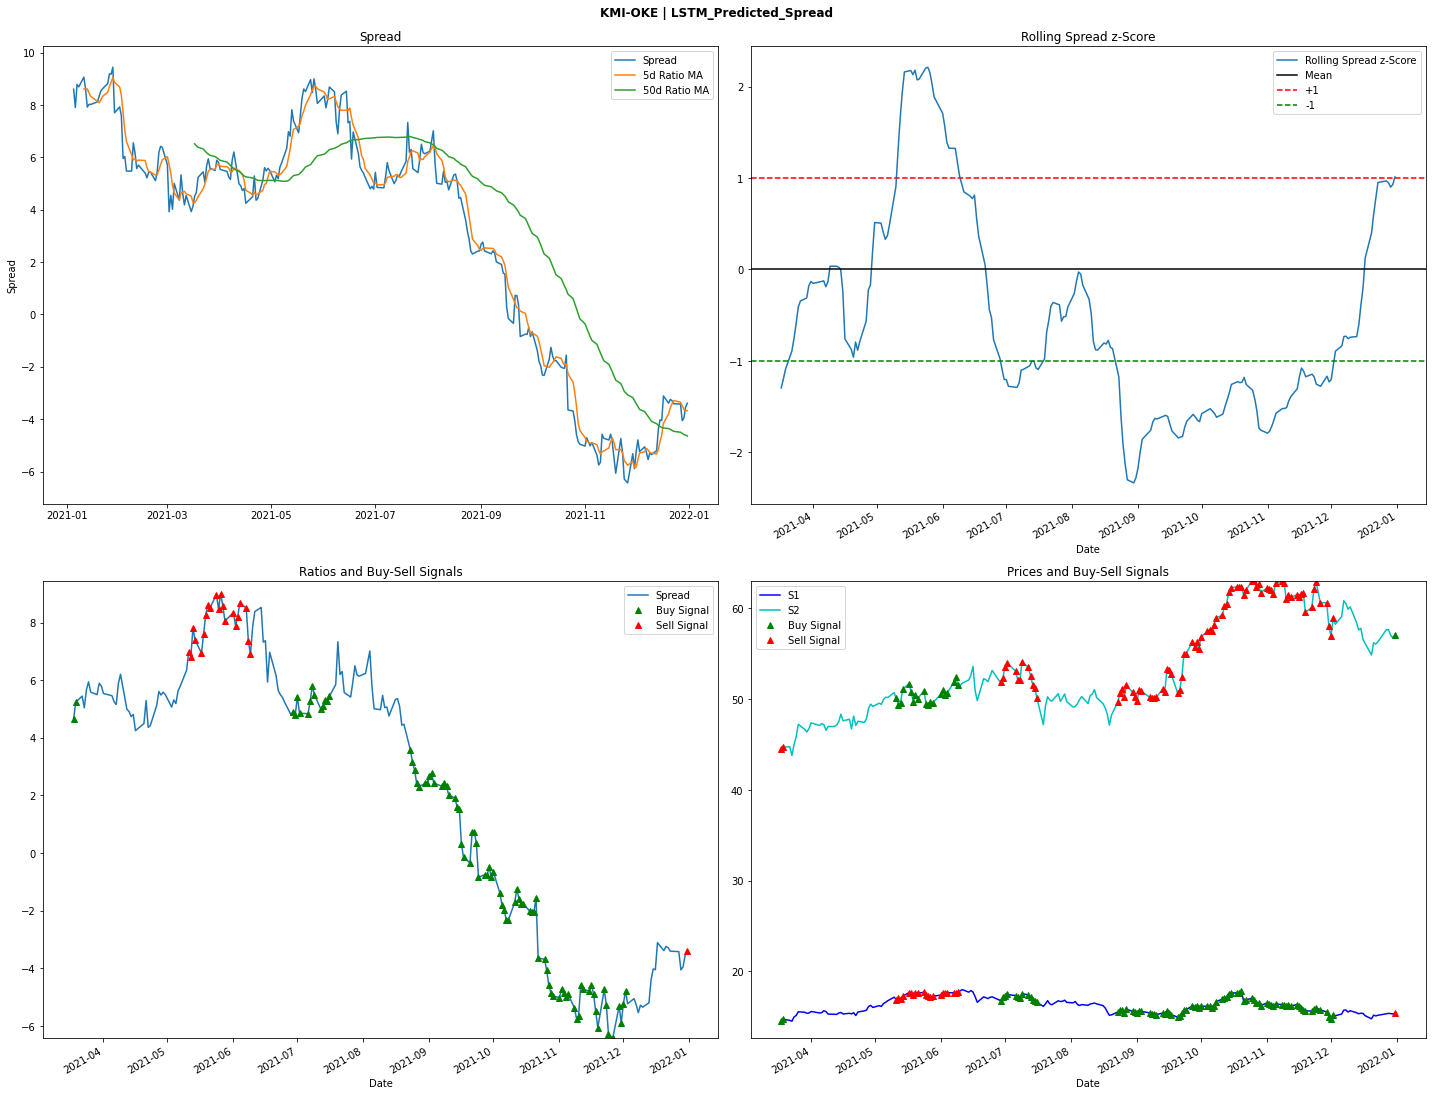


 Cumulative Returns 




=========== HUM-UNH ===========

Actual_Spread



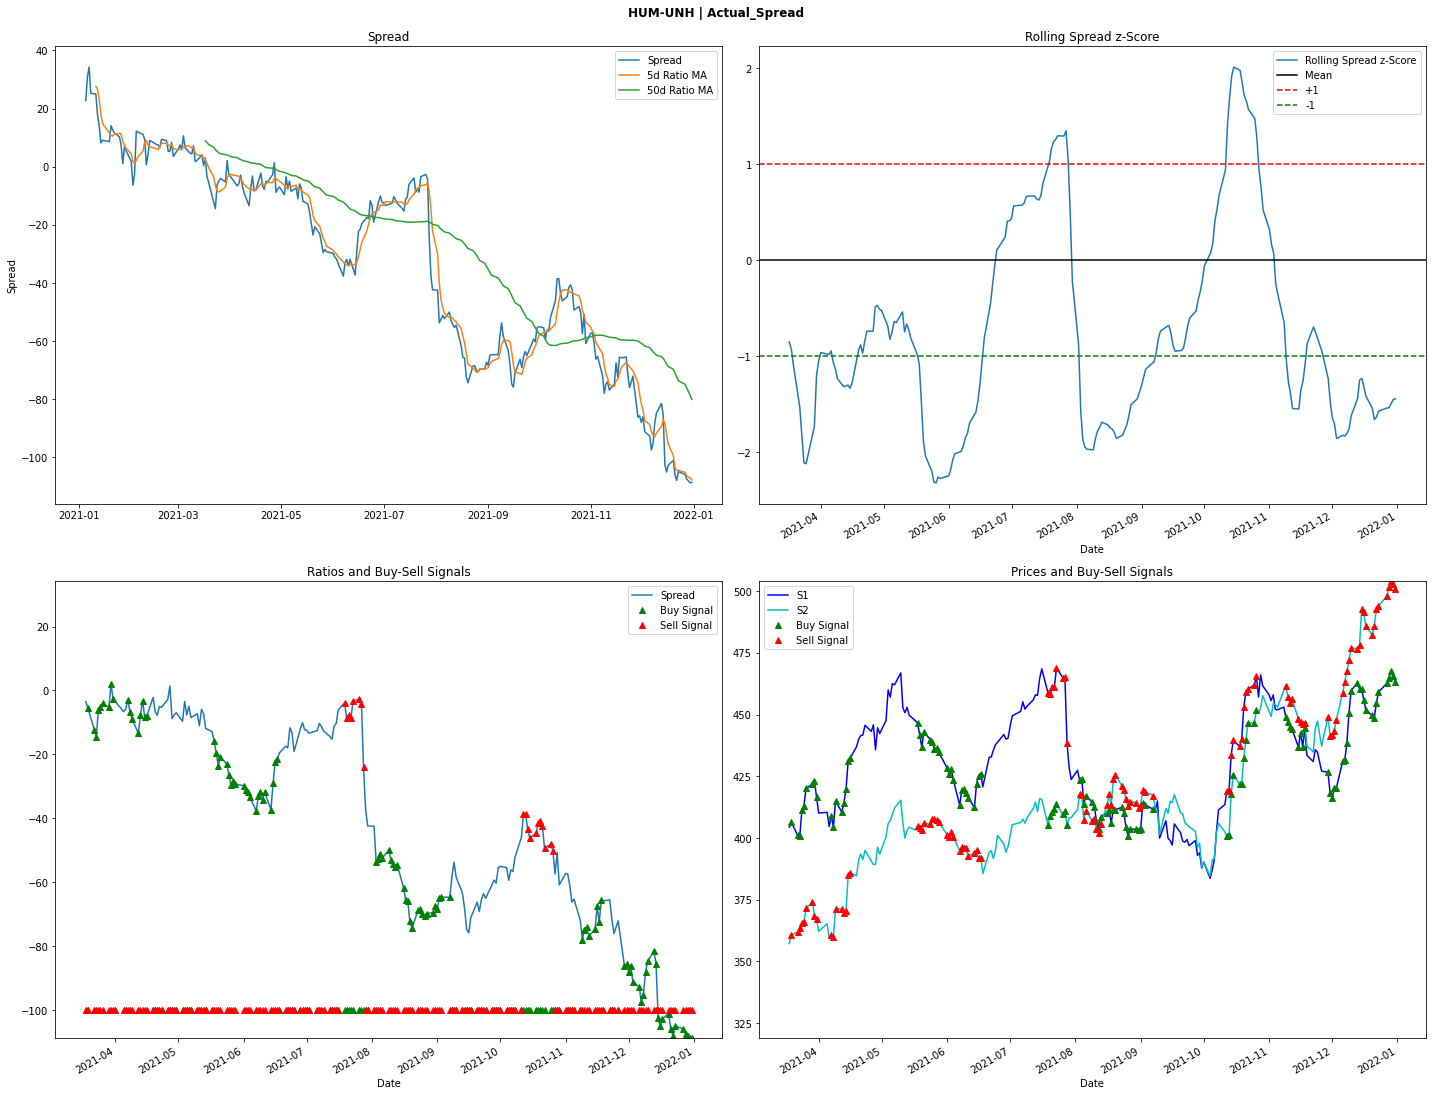


Kalman_Predicted_Spread



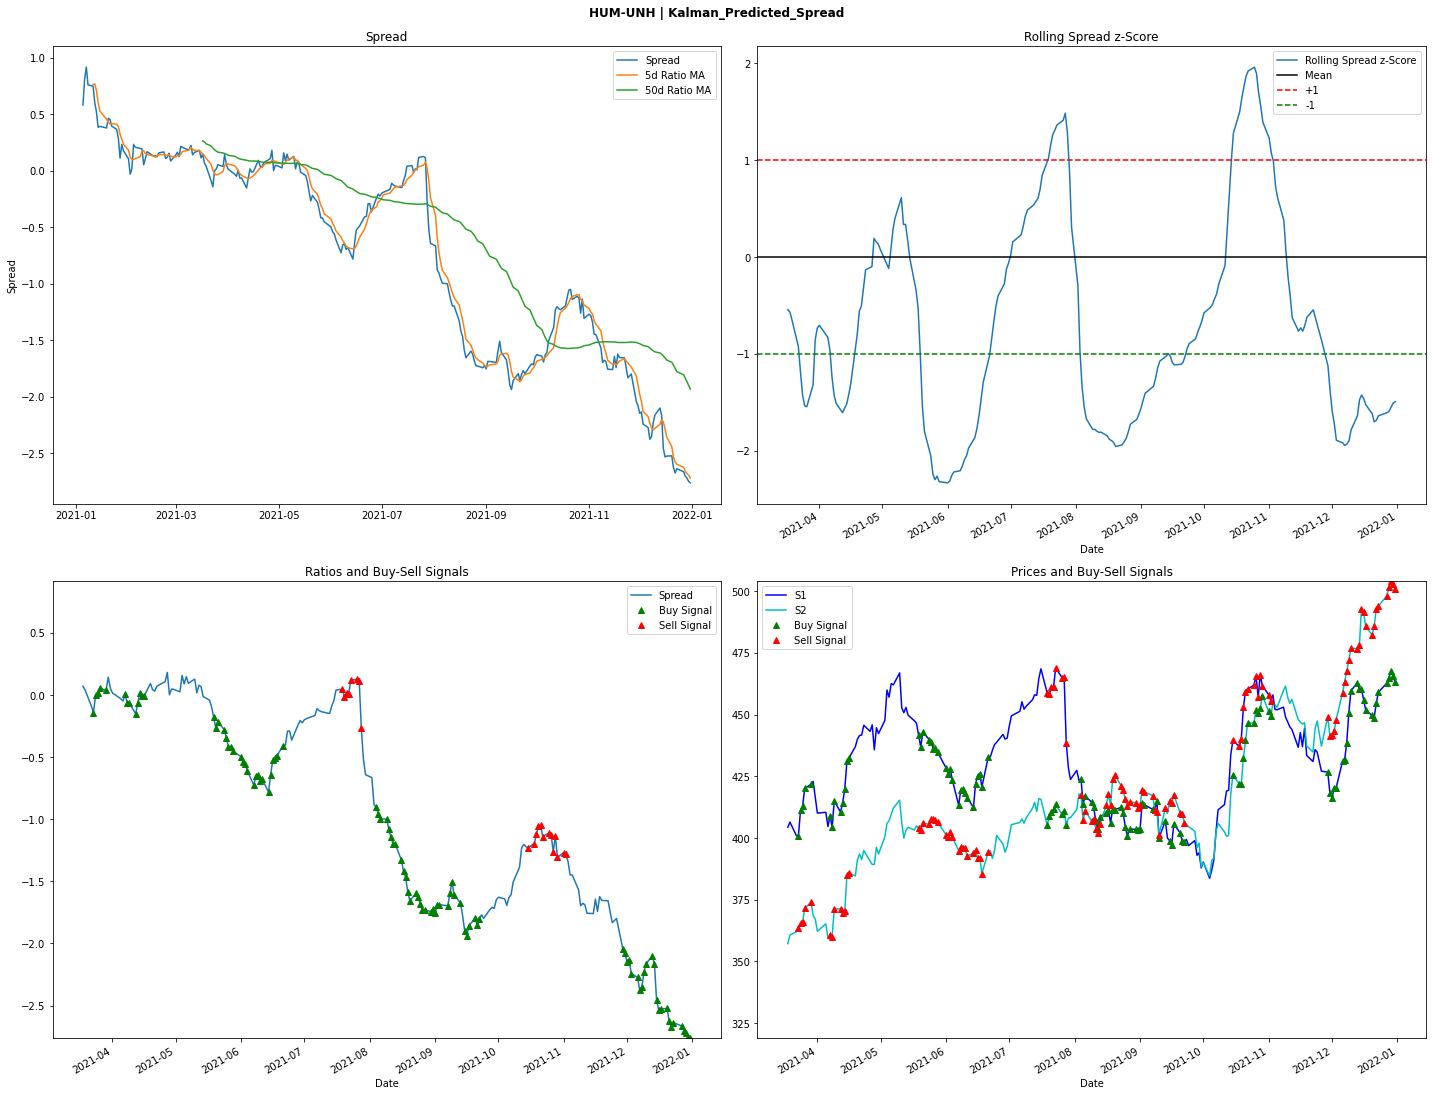


LSTM_Predicted_Spread



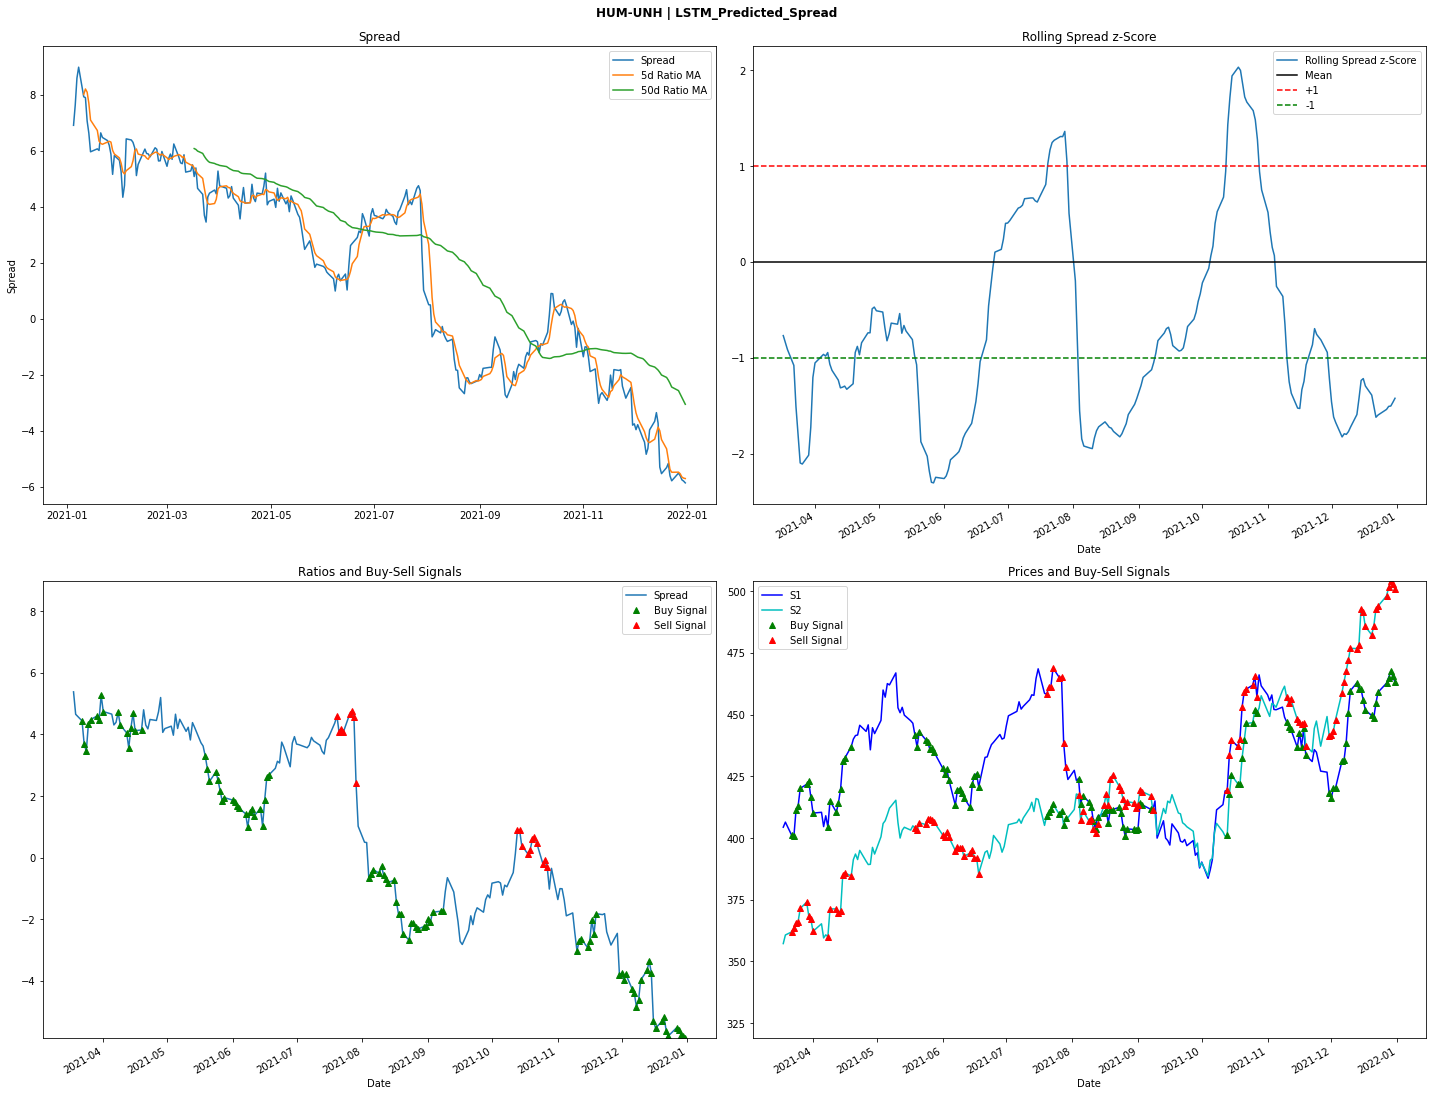


 Cumulative Returns 




=========== ETR-AEP ===========

Actual_Spread



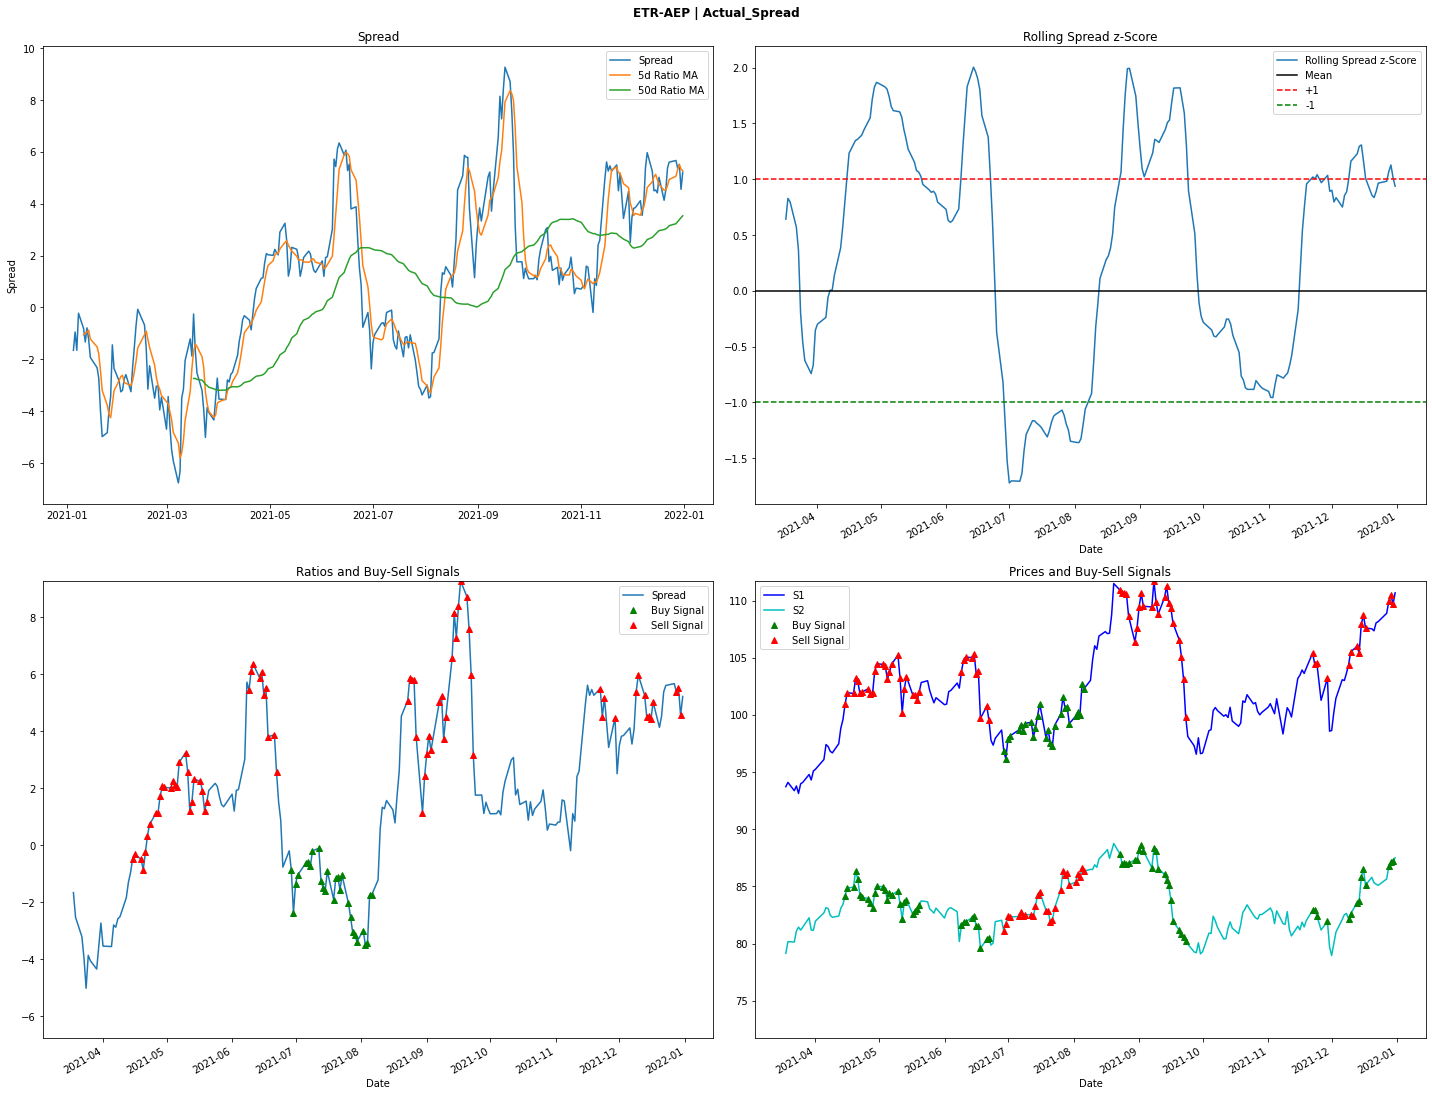


Kalman_Predicted_Spread



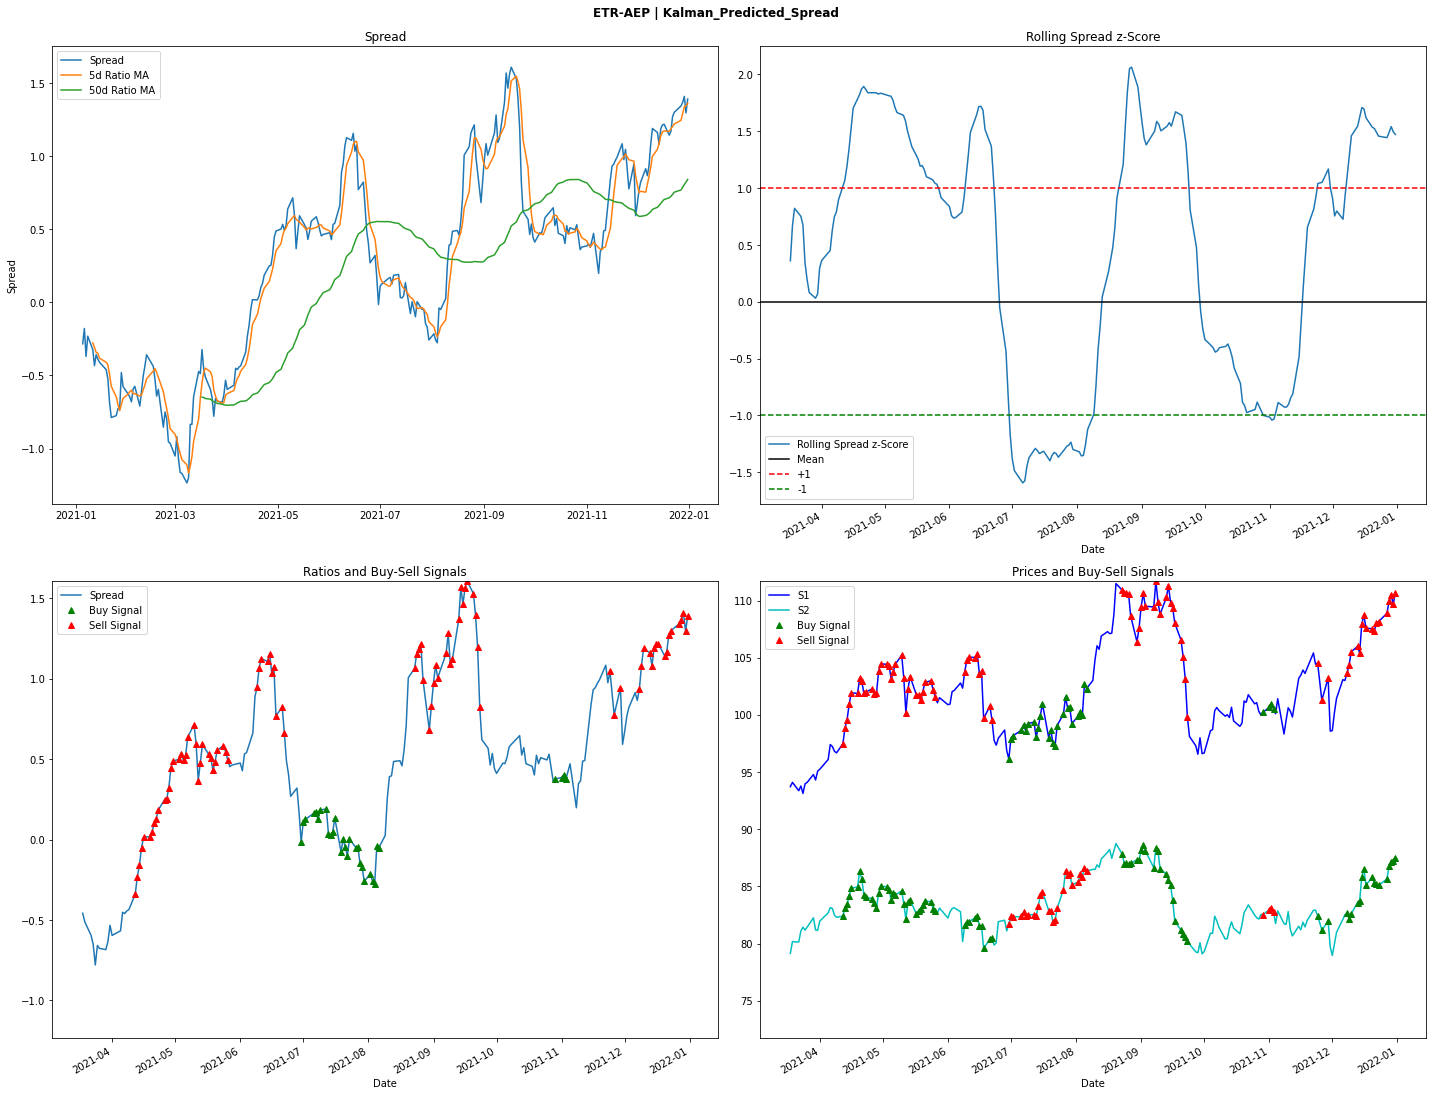


LSTM_Predicted_Spread



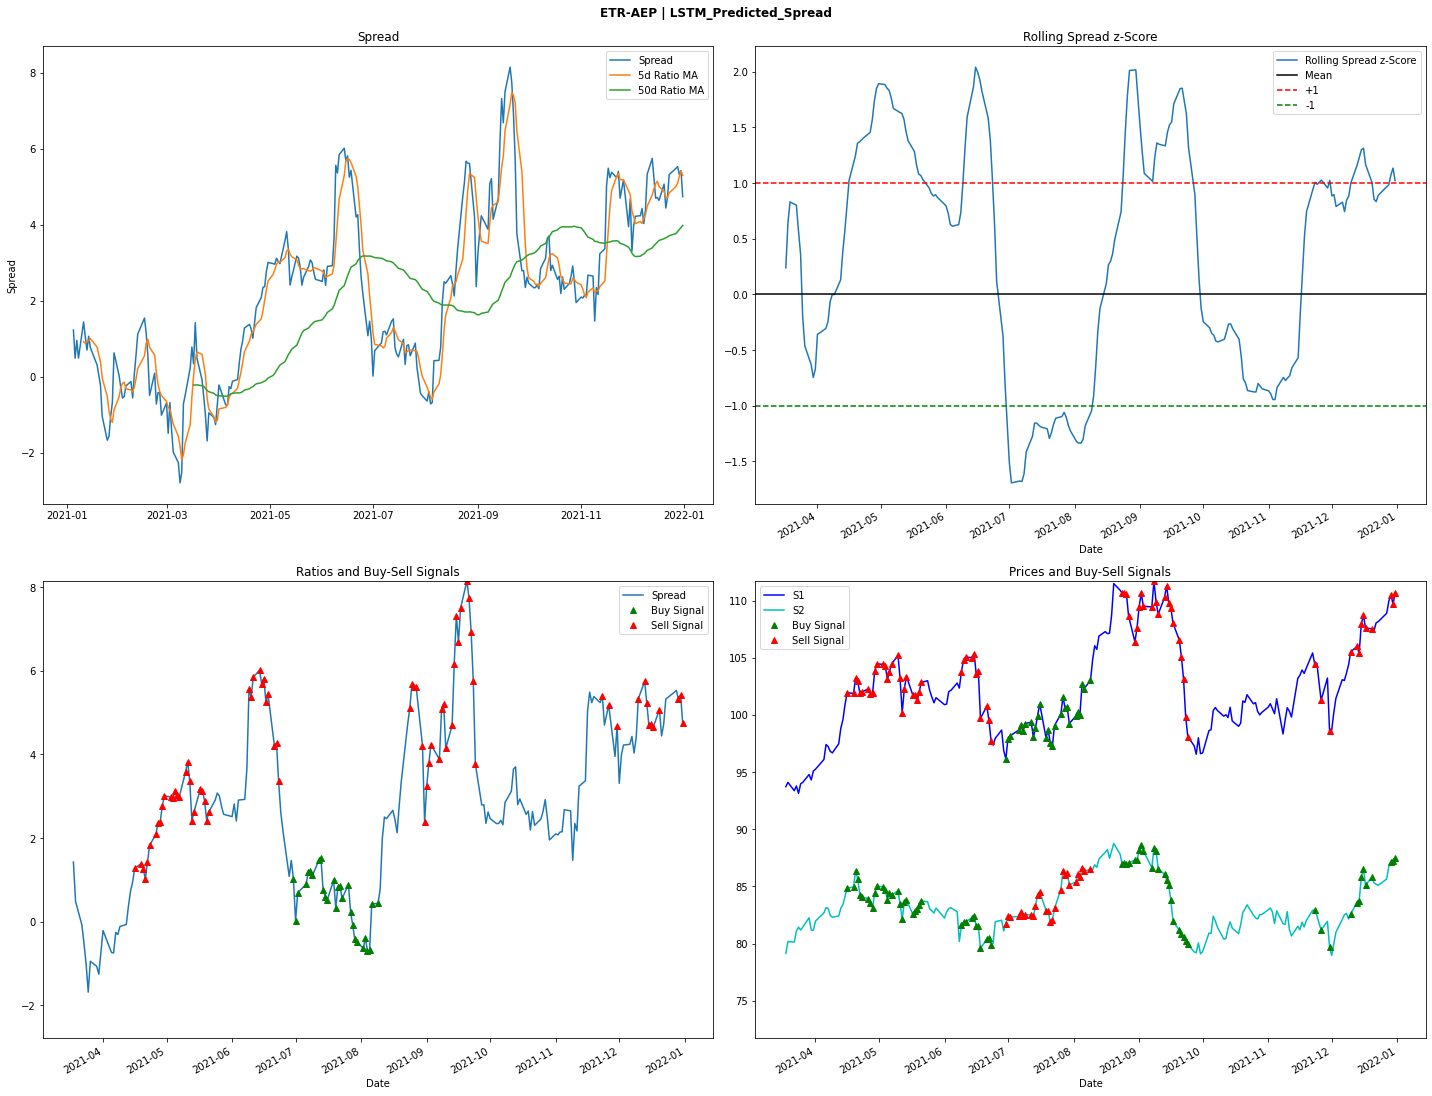


 Cumulative Returns 



In [ ]:
profit_dict = {} # store profits from trading strategy

for trade_pair_name,dictionary in df_pair_dict.items():
    
    print(f'\n=========== {trade_pair_name} ===========')
    df = dictionary['dataframe']
    s1,s2,_ = df.columns.values.tolist()

    df_spread = dictionary['df_spread']
    testX, yhat_LSTM, yhat_KF = dictionary['testX'],dictionary['yhat_LSTM'],dictionary['yhat_KF']

    test_data = pd.DataFrame({'S1':df_spread[s1].iloc[-len(testX):],'S2':df_spread[s2].iloc[-len(testX):]})
    test_data['Actual_Spread'] = df_spread['Spread_Close'].iloc[-len(testX):]
    test_data['Kalman_Predicted_Spread']  = yhat_KF
    test_data['LSTM_Predicted_Spread'] = list(yhat_LSTM[:,0])

    method_list = ['Actual_Spread','Kalman_Predicted_Spread','LSTM_Predicted_Spread']
    
    new_dict = {}
    return_dict = {}
    for method in method_list:

        print(f'\n{method}\n')

        '''========= Spread =========='''
        data = test_data[method]
        rolling_window = 50 # define rolling window
        ratios_mavg5 = data.rolling(window=5,
                                      center=False).mean()
        ratios_mavg_rolling_window = data.rolling(window=rolling_window,
                                      center=False).mean()
        std_rolling_window = data.rolling(window=rolling_window,
                                center=False).std()
        
        zscore_rolling_window_5 = (ratios_mavg5 - ratios_mavg_rolling_window)/std_rolling_window
        pyplot.figure(figsize=(20,15))

        pyplot.subplot(2, 2, 1)
        pyplot.plot(data.index, data.values)
        pyplot.plot(ratios_mavg5.index, ratios_mavg5.values)
        pyplot.plot(ratios_mavg_rolling_window.index, ratios_mavg_rolling_window.values)
        pyplot.legend(['Spread','5d Ratio MA', f'{rolling_window}d Ratio MA'])
        pyplot.ylabel('Spread')
        pyplot.title('Spread')
        #pyplot.show()

        '''========= Rolling Spread z-Score =========='''
        # Take a rolling 10 day standard deviation
        std_rolling_window = data.rolling(window=rolling_window,center=False).std()
        std_rolling_window.name = f'std {rolling_window}d'

        # Compute the z score for each day
        zscore_rolling_window_5 = (ratios_mavg5 - ratios_mavg_rolling_window)/std_rolling_window
        zscore_rolling_window_5.name = 'z-score'

        #pyplot.figure(figsize=(15,7))
        pyplot.subplot(2, 2, 2)
        zscore_rolling_window_5.plot()
        pyplot.axhline(0, color='black')
        pyplot.axhline(1.0, color='red', linestyle='--')
        pyplot.axhline(-1.0, color='green', linestyle='--')
        pyplot.legend(['Rolling Spread z-Score', 'Mean', '+1', '-1'])
        pyplot.title('Rolling Spread z-Score')
        #pyplot.show()

        '''========= Ratios and Buy-Sell Signals =========='''
        # Plot the ratios and buy and sell signals from z score
        #pyplot.figure(figsize=(15,7))
        pyplot.subplot(2, 2, 3)

        buy_signal_threshold = -1 # default -1
        sell_signal_threshold = 1 # default 1

        data[rolling_window:].plot()
        buy = data.copy()
        sell = data.copy()
        buy[zscore_rolling_window_5 > buy_signal_threshold] = -100
        sell[zscore_rolling_window_5 < sell_signal_threshold] = -100
        buy[rolling_window:].plot(color='g', linestyle='None', marker='^')
        sell[rolling_window:].plot(color='r', linestyle='None', marker='^')
        x1,x2,y1,y2 = pyplot.axis()
        pyplot.axis((x1,x2,data.min(),data.max()))
        pyplot.legend(['Spread', 'Buy Signal', 'Sell Signal'])
        pyplot.title('Ratios and Buy-Sell Signals')
        #pyplot.show()

        '''========= Prices and Buy-Sell Signals =========='''
        # Plot the prices and buy and sell signals from z score
        #pyplot.figure(figsize=(18,9))
        pyplot.subplot(2, 2, 4)

        S1 = test_data['S1']
        S2 = test_data['S2']
        S1[rolling_window:].plot(color='b')
        S2[rolling_window:].plot(color='c')
        buyR = 0*S1.copy()
        sellR = 0*S1.copy()

        # When buying the ratio, buy S1 and sell S2
        buyR[buy!=-100] = S1[buy!=-100]
        sellR[buy!=-100] = S2[buy!=-100]
        # When selling the ratio, sell S1 and buy S2 
        buyR[sell!=-100] = S2[sell!=-100]
        sellR[sell!=-100] = S1[sell!=-100]

        buyR[rolling_window:].plot(color='g', linestyle='None', marker='^')
        sellR[rolling_window:].plot(color='r', linestyle='None', marker='^')
        x1,x2,y1,y2 = pyplot.axis()
        pyplot.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

        pyplot.legend(['S1', 'S2', 'Buy Signal', 'Sell Signal'])
        pyplot.title('Prices and Buy-Sell Signals')
        pyplot.suptitle(f'{trade_pair_name} | {method}',y=1, horizontalalignment='center', verticalalignment='bottom',fontweight ="bold")
        pyplot.tight_layout()
        pyplot.show()

        '''============ Simulate trading, Calculate cumulative returns and sharpe ratio =============='''
        # define trade window
        window1 = 25 
        window2 = 5

        #cum_profit,df_return = trade(test_data['S1'], test_data['S2'], test_data[method], window1, window2)

        money,df_return = trade(test_data['S1'], test_data['S2'], test_data[method], window1, window2,s1,s2)
        cum_profit = df_return['cum_return'][-1] # get total cumulative returns (unrealised and realised)
        annual_sharpe_ratio = calculate_sharpe_ratio(daily_return=df_return['daily_return'], risk_free_rate=0.0)
        # update method with cum_profit and sharpe_ratio
        dic = {'cum_return':cum_profit,'sharpe_ratio':annual_sharpe_ratio}
        new_dict.update({method:dic})
        #update return dict
        return_dict.update({method:df_return})

    #update profit dict with cum_profit and sharpe_ratio
    profit_dict.update({trade_pair_name:new_dict})

    '''============ Plot Cumulative Returns =============='''
    print(f'\n Cumulative Returns \n')
    predictDates = df_return.index
    actual_cum_returns = return_dict['Actual_Spread']['cum_return']
    kalman_cum_returns = return_dict['Kalman_Predicted_Spread']['cum_return']
    lstm_cum_returns = return_dict['LSTM_Predicted_Spread']['cum_return']

    #Plot predicted and actual line graph
    layout = go.Layout(
            title=f'{trade_pair_name} : Cumulative Returns vs Time',
            xaxis=dict(
            title='Time Period',
            titlefont=dict(
                family='Arial, sans-serif',
                size=18
            )),
            yaxis=dict(
            title='Cumulative Returns/USD',
            titlefont=dict(
                family='Arial, sans-serif',
                size=18
            )))
    actual_chart = go.Scatter(x=predictDates, y=actual_cum_returns , name= 'Actual Spread - Returns')
    predict_lstm_chart = go.Scatter(x=predictDates, y=lstm_cum_returns, name= 'LSTM Predict Spread - Returns')
    predict_kalman_chart = go.Scatter(x=predictDates, y=kalman_cum_returns, name= 'Kalman Filter Predict Spread - Returns')
    fig = go.Figure(data = [actual_chart,predict_lstm_chart,predict_kalman_chart], layout = layout)
    py.iplot(fig)



In [ ]:
def print_profit(dct):
    print("Cumulative Returns")
    for method, dic in dct.items():  # dct.iteritems() in Python 2
        ret = dic['cum_return']
        sr = dic['sharpe_ratio']
        print(f'\n{method}:')
        print('Cumulative Returns = {}'.format(round(ret,2)))
        print('Sharpe Ratio = {}'.format(round(sr,2)))
        #print("{} = {}".format(method, round(profit,2)))

for trade_pair_name,dictionary in profit_dict.items():
    print(f'\n\n======== {trade_pair_name} ========')
    print_profit(dictionary)
    #print(dictionary)



======== KMI-OKE ========
Cumulative Returns

Actual_Spread:
Cumulative Returns = -303062.08
Sharpe Ratio = 4.19

Kalman_Predicted_Spread:
Cumulative Returns = -240739.5
Sharpe Ratio = 4.66

LSTM_Predicted_Spread:
Cumulative Returns = -27119.53
Sharpe Ratio = -0.98


======== HUM-UNH ========
Cumulative Returns

Actual_Spread:
Cumulative Returns = -2119793.01
Sharpe Ratio = 1.87

Kalman_Predicted_Spread:
Cumulative Returns = -80405.92
Sharpe Ratio = 2.26

LSTM_Predicted_Spread:
Cumulative Returns = -114587.06
Sharpe Ratio = 3.69


======== ETR-AEP ========
Cumulative Returns

Actual_Spread:
Cumulative Returns = 56983.72
Sharpe Ratio = 2.16

Kalman_Predicted_Spread:
Cumulative Returns = -15492.6
Sharpe Ratio = 0.88

LSTM_Predicted_Spread:
Cumulative Returns = 55163.29
Sharpe Ratio = 0.89


# Basic Mean Reversion Strategy

The Kalman Filter is used to dynamically track the hedging ratio between the two in order to keep the spread stationary (and hence mean reverting).

To create the trading rules it is necessary to determine when the spread has moved too far from its expected value.


In [ ]:
!pip install pykalman


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 228 kB 4.3 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48462 sha256=975bd66ed6f6c690e17448282aa9b67901318950298e9088ce7623aa4fc5ed80
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [ ]:
from pykalman import KalmanFilter
import numpy as np

In [ ]:
'''
pair1 = ["KMI", "WMB"]
pair2 = ["OKE", "WMB"]
pair3 = ["KMI", "OKE"]
pair4 = ["CI", "ANTM"]
pair5 = ["UNH", "MOH"]
pair6 = ["LNT", "ED"]
pair7 = ["DUK", "ED"]
pair8 = ["DUK", "LNT"]
'''

pair1 = ["KMI", "OKE"]
pair2 = ["HUM","UNH"]
pair3 = ["ETR","AEP"]

In [ ]:
#start_date = '2019-01-01'
'''
start_date = '2019-01-01'
end_date = '2022-01-01'

def get_df(list_tickers):
  df = pd.DataFrame()
  for ticker in list_tickers:
    current = yf.Ticker(ticker).history(start=start_date, end=end_date).filter(["Close"], axis=1).rename({"Close": ticker}, axis=1)
    df = pd.concat([df, current], axis=1)
  return df
'''

'\nstart_date = \'2019-01-01\'\nend_date = \'2022-01-01\'\n\ndef get_df(list_tickers):\n  df = pd.DataFrame()\n  for ticker in list_tickers:\n    current = yf.Ticker(ticker).history(start=start_date, end=end_date).filter(["Close"], axis=1).rename({"Close": ticker}, axis=1)\n    df = pd.concat([df, current], axis=1)\n  return df\n'

Below is the source code for calculating the moving average and regression with Kalman Filter. <br>
The Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones. 


In [ ]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

Rules: <br>
When Z-score crosses upper entry Z-score, go SHORT; close the position with Z-score return exit Z-score <br>
When Z-score crosses lower entry Z-score, go LONG; close the position with Z-score return exit Z-score

In [ ]:
def backtest(list_tickers):
    #############################################################
    # INPUT:
    # List of ticker pair
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate

    df = get_df(list_tickers)
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    s1 = list_tickers[0]
    s2 = list_tickers[1]
    x = df[s1]
    y = df[s2]
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    # Spread = Y - Hedge Ratio * X
    df1['spread'] = df1.y + (df1.x * df1.hr)
    # calculate half life
    halflife = half_life(df1['spread'])
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    print(df1)
    ##############################################################
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR

In [ ]:
pairs = [pair1, pair2, pair3, pair4, pair5, pair6, pair7, pair8, pair9, pair10, pair11, pair12, pair13, pair14, pair15,
         pair16, pair17, pair18, pair19, pair20, pair21, pair22, pair23, pair24, pair25, pair26, pair27, pair28, pair29, pair30]
results = []
for pair in pairs:
    rets, sharpe,  CAGR = backtest(pair)
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets.plot(figsize=(20,15),legend=True)

NameError: ignored